# Recency, Frequency and Monetary Analysis on H&M Data

## 1 Import libraries

In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## 2 Data pre-processing for RFM
- Check variables
- Derive Recency, Frequency and Monetary variables

### 2.1 Read in CSV and Conduct Basic Analysis

In [3]:
# Read in CSV
df = pd.read_csv('data/transactions_train.csv')
print('Dataframe shape:',df.shape)
print('Columns:',list(df.columns))
df.head()

Dataframe shape: (31788324, 5)
Columns: ['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id']


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [4]:
# Basic data check: Check for null values
for col in df.columns:
    print("Number of Null Values in", col, " : ", len(df[df[col].isna()]), "/", len(df))

Number of Null Values in t_dat  :  0 / 31788324
Number of Null Values in customer_id  :  0 / 31788324
Number of Null Values in article_id  :  0 / 31788324
Number of Null Values in price  :  0 / 31788324
Number of Null Values in sales_channel_id  :  0 / 31788324


In [5]:
# Basic data check: Check data types
df.dtypes

t_dat                object
customer_id          object
article_id            int64
price               float64
sales_channel_id      int64
dtype: object

In [6]:
# Change data type
df = df.astype({'t_dat':'datetime64[ns]',
                'customer_id':'str',
                'article_id':'str',
                'price':'float',
                'sales_channel_id':'str'})
df.dtypes

t_dat               datetime64[ns]
customer_id                 object
article_id                  object
price                      float64
sales_channel_id            object
dtype: object

In [7]:
# Subset relevant columns and 
# Change order of dataframe to place customer_id at the front
cols = ['customer_id','t_dat','price','article_id','sales_channel_id']
df_new = df[cols]
df_new.head()

,customer_id,t_dat,price,article_id,sales_channel_id
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,2018-09-20,0.050831,663713001,2
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,2018-09-20,0.030492,541518023,2
2,00007d2de826758b65a93dd24ce629ed66842531df6699...,2018-09-20,0.015237,505221004,2
3,00007d2de826758b65a93dd24ce629ed66842531df6699...,2018-09-20,0.016932,685687003,2
4,00007d2de826758b65a93dd24ce629ed66842531df6699...,2018-09-20,0.016932,685687004,2


### 2.2 Create dataframe for RFM analysis

#### Check number of unique customers

In [8]:
# Check number of unique customers
len(df['customer_id'].unique())

1362281

#### Recency

In [9]:
# Subset dataset to get customer_id and t_dat to compute recency
df_recency = df_new.loc[:,['customer_id','t_dat']]
print(len(df_recency) == len(df)) # check
# df_recency.head()

True


In [10]:
print(df_recency['t_dat'].max())

2020-09-22 00:00:00


In [11]:
# Get last date of purchase
df_recency = pd.DataFrame(df_recency.groupby('customer_id')['t_dat'].max()).reset_index()
print(len(df_recency) == len(df_new['customer_id'].unique()))
# df_recency.head()

True


In [12]:
# Calculate recency based on 2020-10-01
date = dt.datetime(2020, 10, 1)
df_recency['Recency'] = df_recency.t_dat.apply(lambda x:(date - x).days)
df_recency.head()

,customer_id,t_dat,Recency
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,2020-09-05,26
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,2020-07-08,85
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,2020-09-15,16
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,2019-06-09,480
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,2020-08-12,50


#### Frequency

In [13]:
# Subset dataset to get customer_id and t_dat to compute frequency
df_frequency = df_new.loc[:,['customer_id','t_dat']]
print(len(df_frequency) == len(df)) # check
# df_frequency.head()

True


In [14]:
# Calculate frequency based on total number of purchases
df_frequency = pd.DataFrame(df_frequency.groupby('customer_id')['t_dat'].count()).reset_index()
print(len(df_frequency) == len(df_new['customer_id'].unique()))
df_frequency.columns = ['customer_id', 'Frequency']
df_frequency.head()

True


,customer_id,Frequency
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,21
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,86
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,18
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,2
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,13


(array([1.349264e+06, 1.158900e+04, 1.151000e+03, 2.010000e+02,
        4.900000e+01, 1.700000e+01, 6.000000e+00, 3.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([1.0000e+00, 1.9040e+02, 3.7980e+02, 5.6920e+02, 7.5860e+02,
        9.4800e+02, 1.1374e+03, 1.3268e+03, 1.5162e+03, 1.7056e+03,
        1.8950e+03]),
 <a list of 10 Patch objects>)

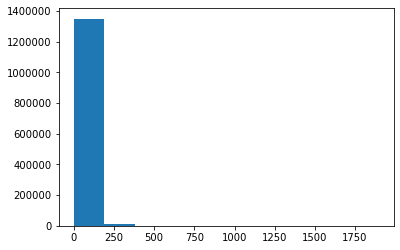

In [15]:
plt.hist(df_frequency['Frequency'])

#### Monetary

In [16]:
# Subset dataset to get customer_id and price to compute monetary
df_monetary = df_new.loc[:,['customer_id','price']]
print(len(df_monetary) == len(df)) # check
# df_monetary.head()

True


In [17]:
# Calculate monetary based on average amount spent per transaction
df_monetary = pd.DataFrame(df_monetary.groupby('customer_id')['price'].mean()).reset_index()
print(len(df_monetary) == len(df_new['customer_id'].unique()))
df_monetary.columns = ['customer_id', 'Monetary']
df_monetary.head()

True


,customer_id,Monetary
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.030904
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.030255
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.039154
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.030492
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0.036130


In [18]:
# Multiply by 1000
df_monetary['Monetary'] = df_monetary['Monetary']*1000
df_monetary.head()

,customer_id,Monetary
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,30.903955
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,30.255026
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,39.154426
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,30.491525
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,36.130378


(array([1.301702e+06, 5.477600e+04, 4.597000e+03, 7.880000e+02,
        2.900000e+02, 7.000000e+01, 3.400000e+01, 6.000000e+00,
        1.700000e+01, 1.000000e+00]),
 array([  0.76271186,  51.36440678, 101.96610169, 152.56779661,
        203.16949153, 253.77118644, 304.37288136, 354.97457627,
        405.57627119, 456.1779661 , 506.77966102]),
 <a list of 10 Patch objects>)

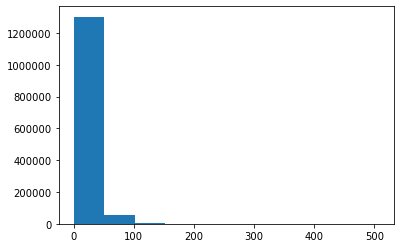

In [19]:
plt.hist(df_monetary['Monetary'])

## 3 RFM analysis
https://github.com/klaudia-nazarko/rfm-analysis-python/blob/master/rfm_analysis_python.ipynb

### 3.1 Combine RFM into a single dataframe
- `Recency`: Number of days from latest transaction date to 2020-10-1 (because the latest t_dat in dataset is 2020-9-22 so chose 2020-10-1 as a reasonable benchmark)
- `Frequency`: Number of transactions per customer_id
- `Money`: Average spending per transaction

In [20]:
df_rfm = pd.merge(df_recency, df_frequency, on='customer_id')
df_rfm = pd.merge(df_rfm, df_monetary, on='customer_id')
df_rfm = df_rfm.drop(['t_dat'], axis=1)
print('Dataframe shape:',df_rfm.shape)
df_rfm.head()

Dataframe shape: (1362281, 4)


,customer_id,Recency,Frequency,Monetary
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,26,21,30.903955
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,85,86,30.255026
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,16,18,39.154426
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,480,2,30.491525
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,50,13,36.130378


#### Normalize by scaling

In [21]:
# MinMaxScaler - couln't really differentiate between segments
# from sklearn import preprocessing

# rfm = df_rfm.drop(['customer_id'], axis=1)
# x = rfm.values # returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# rfm = pd.DataFrame(x_scaled, columns=['Recency_norm','Frequency_norm','Monetary_norm'])
# rfm.head()

In [22]:
# StandardScaler
from sklearn.preprocessing import StandardScaler

rfm = df_rfm.drop(['customer_id'], axis=1)

scaler = StandardScaler()
scaler.fit(rfm)
customers_normalized = scaler.transform(rfm)

rfm = pd.DataFrame(customers_normalized, columns=['Recency_norm','Frequency_norm','Monetary_norm'])
rfm.head()

# Assert that it has mean 0 and variance 1
print(customers_normalized.mean(axis = 0).round(2)) # [0. -0. 0.]
print(customers_normalized.std(axis = 0).round(2)) # [1. 1. 1.]

[-0.  0. -0.]
[1. 1. 1.]


In [23]:
rfm.insert(0, "customer_id", df_rfm.customer_id)
rfm.head()

,customer_id,Recency_norm,Frequency_norm,Monetary_norm
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,-0.986567,-0.059493,0.150363
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,-0.719742,1.596886,0.104962
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,-1.031792,-0.135941,0.727586
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,1.066629,-0.543665,0.121508
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,-0.878028,-0.263355,0.516016


In [24]:
df_rfm['Recency_norm'] = rfm['Recency_norm']
df_rfm['Frequency_norm'] = rfm['Frequency_norm']
df_rfm['Monetary_norm'] = rfm['Monetary_norm']
df_rfm.head()

,customer_id,Recency,Frequency,Monetary,Recency_norm,Frequency_norm,Monetary_norm
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,26,21,30.903955,-0.986567,-0.059493,0.150363
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,85,86,30.255026,-0.719742,1.596886,0.104962
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,16,18,39.154426,-1.031792,-0.135941,0.727586
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,480,2,30.491525,1.066629,-0.543665,0.121508
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,50,13,36.130378,-0.878028,-0.263355,0.516016


In [25]:
# Check
print(min(df_rfm['Recency_norm']), max(df_rfm['Recency_norm']))
print(min(df_rfm['Frequency_norm']), max(df_rfm['Frequency_norm']))
print(min(df_rfm['Monetary_norm']), max(df_rfm['Monetary_norm']))

-1.0634488456797293 2.251512604187681
-0.5691477170113969 47.69517292835603
-1.9583939182578476 33.44381674428862


(array([1.349264e+06, 1.158900e+04, 1.151000e+03, 2.010000e+02,
        4.900000e+01, 1.700000e+01, 6.000000e+00, 3.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([-0.56914772,  4.25728435,  9.08371641, 13.91014848, 18.73658054,
        23.56301261, 28.38944467, 33.21587673, 38.0423088 , 42.86874086,
        47.69517293]),
 <a list of 10 Patch objects>)

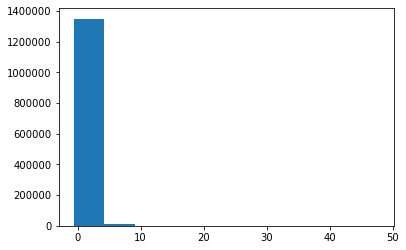

In [26]:
plt.hist(df_rfm['Frequency_norm'])

(array([1.301702e+06, 5.477600e+04, 4.597000e+03, 7.880000e+02,
        2.900000e+02, 7.000000e+01, 3.400000e+01, 6.000000e+00,
        1.700000e+01, 1.000000e+00]),
 array([-1.95839392,  1.58182715,  5.12204821,  8.66226928, 12.20249035,
        15.74271141, 19.28293248, 22.82315355, 26.36337461, 29.90359568,
        33.44381674]),
 <a list of 10 Patch objects>)

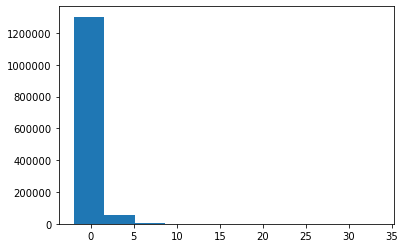

In [27]:
plt.hist(df_rfm['Monetary_norm'])

### 3.2 Conduct RFM Analysis by grouping customers into segments
- Recency: (shortened interval because shopping for clothes is a necessity)
    - Active: Purchase within past 6 months
    - Warm: Purchase within past 1 year
    - Cold/Lost: Purchase beyond 1 year
- Frequency:
    - Frequent: Top 20%
    - Less frequent: Bottom 80%
- Monetary:
    - Valuable: Top 20%
    - Less valuable: Bottom 80%

In [28]:
# assign recency label
bins = [0,6*30,12*30,1000]

r_labels = ['Active','Warm','Cold/Lost']
df_rfm['r_label'] = pd.cut(df_rfm['Recency'], bins=bins, labels=r_labels, right=False)

# r_scores = [4,3,2,1]
# df_rfm['r_score'] = pd.cut(df_rfm['Recency'], bins=bins, labels=r_scores, right=False).astype(int)

In [29]:
# assign frequency label
#bins = [0, np.percentile(df_rfm.Frequency_norm,20), 1.1]
bins = [min(df_rfm.Frequency_norm)-0.01, np.percentile(df_rfm.Frequency_norm,20), max(df_rfm.Frequency_norm)+0.01]

f_labels = ['Less frequent','Frequent']
df_rfm['f_label'] = pd.cut(df_rfm['Frequency_norm'], bins=bins, labels=f_labels, right=False)

# f_scores = [1,2,3]
# df_rfm['f_score'] = pd.qcut(df_rfm['Frequency'], q=3, labels=f_scores).astype(int)

In [30]:
# assign monetary label
#bins = [0, np.percentile(df_rfm.Monetary_norm,20), 1.1]
bins = [min(df_rfm.Monetary_norm)-0.01, np.percentile(df_rfm.Monetary_norm,20), max(df_rfm.Monetary_norm)+0.01]

m_labels = ['Less valuable','Valuable']
df_rfm['m_label'] = pd.cut(df_rfm['Monetary_norm'], bins=bins, labels=m_labels, right=False)

# m_scores = [2,1]
# df_rfm['m_score'] = pd.cut(df_rfm['Monetary'], bins=bins, labels=m_scores, right=False).astype(int)

In [31]:
# Add a column to sum rfm scores
# df_rfm['rfm_sum'] = df_rfm['r_score'] + df_rfm['f_score'] + df_rfm['m_score']
df_rfm.head()

,customer_id,Recency,Frequency,Monetary,Recency_norm,Frequency_norm,Monetary_norm,r_label,f_label,m_label
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,26,21,30.903955,-0.986567,-0.059493,0.150363,Active,Frequent,Valuable
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,85,86,30.255026,-0.719742,1.596886,0.104962,Active,Frequent,Valuable
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,16,18,39.154426,-1.031792,-0.135941,0.727586,Active,Frequent,Valuable
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,480,2,30.491525,1.066629,-0.543665,0.121508,Cold/Lost,Less frequent,Valuable
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,50,13,36.130378,-0.878028,-0.263355,0.516016,Active,Frequent,Valuable


#### RFM Customer Segments
- Champions: High on all RFM factors
- Loyal: May not have high Monetary, but high on Recency and Frequency (i.e. visits stores often, maybe to check out new goods)
- Provide attention: Customers who have at least 1 high but not more than 2 high out of the RFM attributes (these customers are either willing to pay, willing to visit the store or show interest with their recent visit > therefore, we could try to capture these customers to earn profits from them)
- Unprofitable: No point in investing in these customers as they demonstrate low interest via their visits to the store or amount of purchase made

In [32]:
def assign_label(df, r_label, f_label, m_label, label, colname='rfm_label'):
    df.loc[(df['r_label']==r_label) & (df['f_label']==f_label)
              & (df['m_label']==m_label), colname] = label
    return df

# def assign_label(df, r_rule, f_rule, m_rule, label, colname='rfm_label'):
#     df.loc[(df['r_score'].between(r_rule[0], r_rule[1]))
#             & (df['f_score'].between(f_rule[0], f_rule[1]))
#             & (df['m_score'].between(m_rule[0], m_rule[1])), colname] = label
#     return df

In [33]:
df_rfm['rfm_label'] = ''

df_rfm = assign_label(df_rfm, 'Active', 'Frequent', 'Valuable', 'Champions')
df_rfm = assign_label(df_rfm, 'Active', 'Less frequent', 'Valuable', 'Provide attention')
df_rfm = assign_label(df_rfm, 'Active', 'Frequent', 'Less valuable', 'Loyal')
df_rfm = assign_label(df_rfm, 'Active', 'Less frequent', 'Less valuable', 'Provide attention')

df_rfm = assign_label(df_rfm, 'Warm', 'Frequent', 'Valuable', 'Provide attention')
df_rfm = assign_label(df_rfm, 'Warm', 'Less frequent', 'Valuable', 'Provide attention')
df_rfm = assign_label(df_rfm, 'Warm', 'Frequent', 'Less valuable', 'Provide attention')
df_rfm = assign_label(df_rfm, 'Warm', 'Less frequent', 'Less valuable', 'Provide attention')

df_rfm = assign_label(df_rfm, 'Cold/Lost', 'Frequent', 'Valuable', 'Provide attention')
df_rfm = assign_label(df_rfm, 'Cold/Lost', 'Less frequent', 'Valuable', 'Unprofitable')
df_rfm = assign_label(df_rfm, 'Cold/Lost', 'Frequent', 'Less valuable', 'Unprofitable')
df_rfm = assign_label(df_rfm, 'Cold/Lost', 'Less frequent', 'Less valuable', 'Unprofitable')

In [34]:
print('Dataframe shape:',df_rfm.shape)
df_rfm.head()

Dataframe shape: (1362281, 11)


,customer_id,Recency,Frequency,Monetary,Recency_norm,Frequency_norm,Monetary_norm,r_label,f_label,m_label,rfm_label
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,26,21,30.903955,-0.986567,-0.059493,0.150363,Active,Frequent,Valuable,Champions
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,85,86,30.255026,-0.719742,1.596886,0.104962,Active,Frequent,Valuable,Champions
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,16,18,39.154426,-1.031792,-0.135941,0.727586,Active,Frequent,Valuable,Champions
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,480,2,30.491525,1.066629,-0.543665,0.121508,Cold/Lost,Less frequent,Valuable,Unprofitable
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,50,13,36.130378,-0.878028,-0.263355,0.516016,Active,Frequent,Valuable,Champions


In [35]:
df_rfm['rfm_label'].unique()

array(['Champions', 'Unprofitable', 'Provide attention', 'Loyal'],
      dtype=object)

#### Export clusters

In [36]:
df_clusters = df_rfm.loc[:,['customer_id','rfm_label']]
df_clusters.rename({'rfm_label': 'cluster'}, axis=1, inplace=True)
df_clusters.head()

,customer_id,cluster
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,Champions
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,Champions
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,Champions
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,Unprofitable
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,Champions


In [37]:
df_clusters.to_csv('clusters_4.csv', index=False)

## 3.3 RFM Segment Analysis

### 3.3.1 General Analysis on RFM Segments

#### Number of customers in each RFM Segment defined

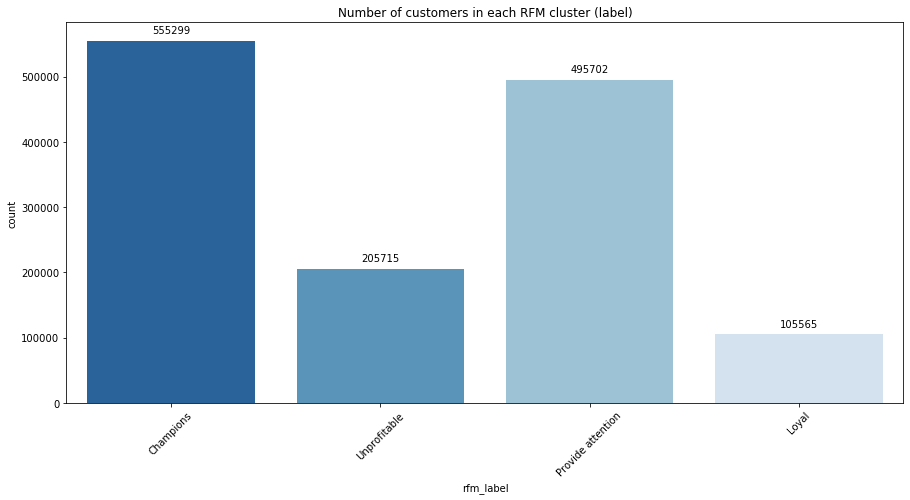

In [38]:
palette = sns.color_palette("Blues_r", n_colors=4)

for rfm_type in ['label']:
    fig, ax = plt.subplots(figsize=(15,7))
    sns.countplot(x='rfm_'+rfm_type, data=df_rfm, palette=palette)
    for p in ax.patches:
        ax.annotate(p.get_height(), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', 
                    va='center', 
                    xytext=(0, 10), 
                    textcoords='offset points')
    ax.set_title('Number of customers in each RFM cluster (%s)' % rfm_type)
    if rfm_type == 'label':
        plt.xticks(rotation=45)
    plt.show()

#### Proportion of customers in each RFM Segment & Proportion of monetary amount by customers in each RFM Segment

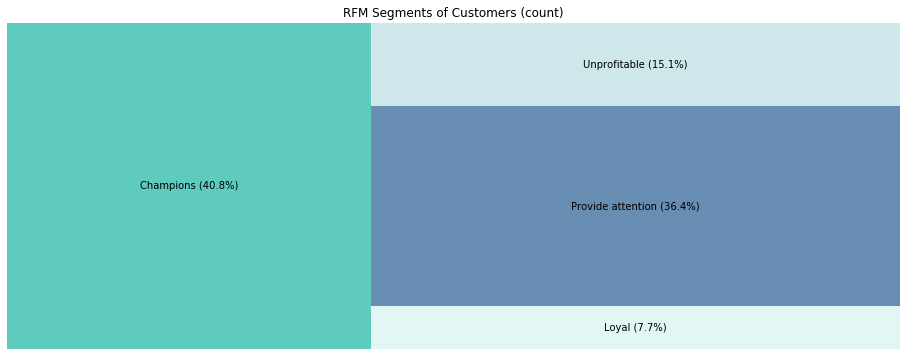

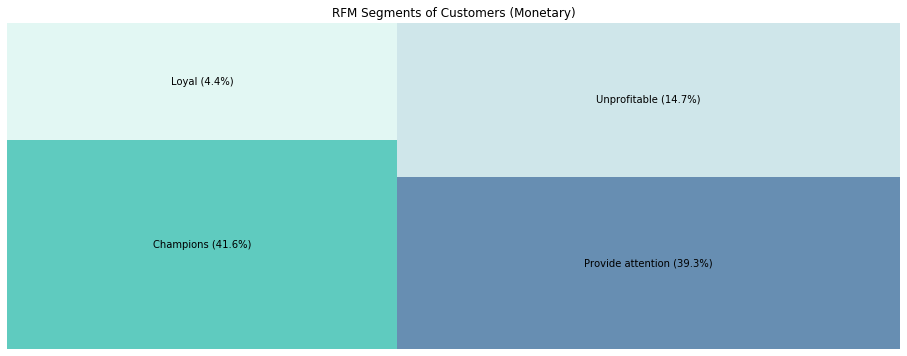

In [39]:
import squarify
agg_dict2 = {
    'customer_id': 'count',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'sum',
    'Recency_norm': 'mean',
    'Frequency_norm': 'mean',
    'Monetary_norm': 'mean'
}

df_analysis = df_rfm.groupby('rfm_label').agg(agg_dict2).sort_values(by='Recency').reset_index()
df_analysis.rename({'rfm_label': 'label', 'customer_id': 'count'}, axis=1, inplace=True)
df_analysis['count_share'] = df_analysis['count'] / df_analysis['count'].sum()
df_analysis['Monetary_share'] = df_analysis['Monetary'] / df_analysis['Monetary'].sum()
df_analysis['Monetary'] = df_analysis['Monetary'] / df_analysis['count']

colors = ['#37BEB0', '#DBF5F0', '#41729F', '#C3E0E5', '#0C6170', '#5885AF', '#E1C340', '#274472', '#F8EA8C', '#A4E5E0', '#1848A0']

for col in ['count', 'Monetary']:
    labels = df_analysis['label'] + df_analysis[col + '_share'].apply(lambda x: ' ({0:.1f}%)'.format(x*100))

    fig, ax = plt.subplots(figsize=(16,6))
    squarify.plot(sizes=df_analysis[col], label=labels, alpha=.8, color=colors)
    ax.set_title('RFM Segments of Customers (%s)' % col)
    plt.axis('off')
    plt.show()

#### View Recency vs Frequency for each RFM Segment for comparison

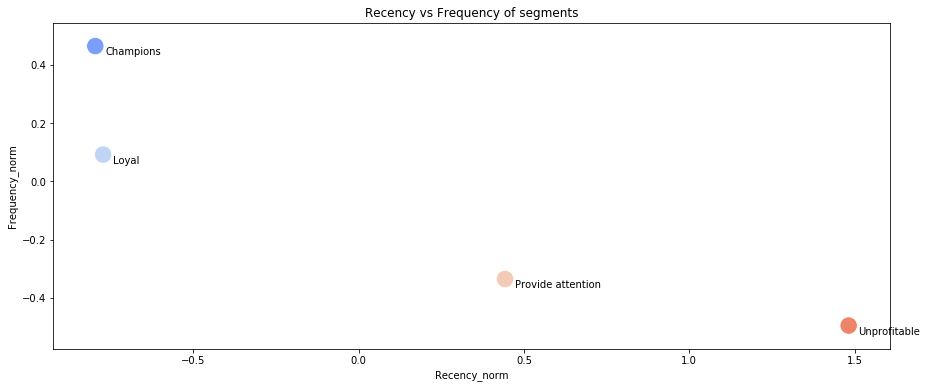

In [40]:
palette = sns.color_palette("coolwarm", 4)

fig, ax = plt.subplots(figsize=(15,6))
plot = sns.scatterplot(x='Recency_norm', y='Frequency_norm', data=df_analysis, hue='label', s=300, palette=palette)

for i in range(len(df_analysis)):
     plot.text(df_analysis['Recency_norm'][i]+0.03, #+0.008,
               df_analysis['Frequency_norm'][i]-0.03, #-0.002,
               df_analysis['label'][i],
               horizontalalignment='left',
               size='medium', color='black')

ax.set_title('Recency vs Frequency of segments')
ax.get_legend().remove()
# plt.legend(loc='upper left')
plt.show()

#### View Recency vs Monetary of each RFM Segment for comparison

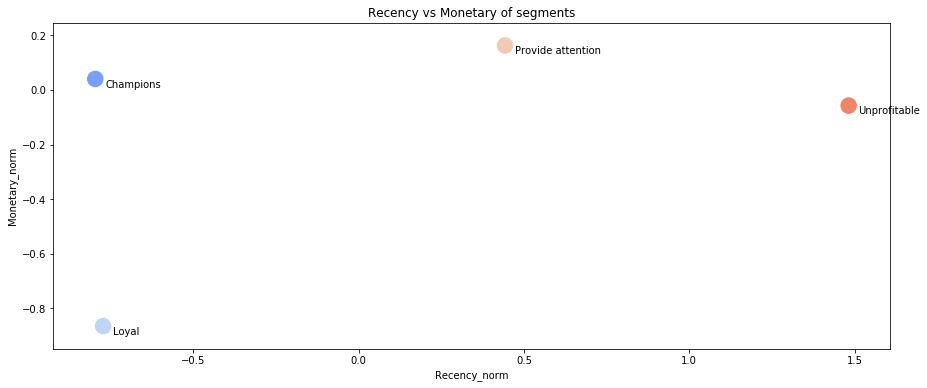

In [41]:
palette = sns.color_palette("coolwarm", 4)

fig, ax = plt.subplots(figsize=(15,6))
plot = sns.scatterplot(x='Recency_norm', y='Monetary_norm', data=df_analysis, hue='label', s=300, palette=palette)

for i in range(len(df_analysis)):
     plot.text(df_analysis['Recency_norm'][i]+0.03, #+0.008,
               df_analysis['Monetary_norm'][i]-0.03, #-0.002,
               df_analysis['label'][i],
               horizontalalignment='left',
               size='medium', color='black')

ax.set_title('Recency vs Monetary of segments')
ax.get_legend().remove()
# plt.legend(loc='upper left')
plt.show()

#### View Frequency vs Monetary of each RFM Segment for comparison

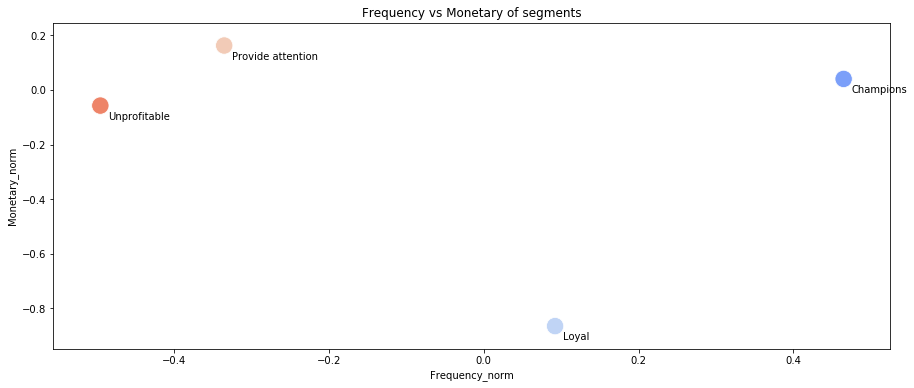

In [42]:
palette = sns.color_palette("coolwarm", 4)

fig, ax = plt.subplots(figsize=(15,6))
plot = sns.scatterplot(x='Frequency_norm', y='Monetary_norm', data=df_analysis, hue='label', s=300, palette=palette)

for i in range(len(df_analysis)):
     plot.text(df_analysis['Frequency_norm'][i]+0.01, #+0.0008,
               df_analysis['Monetary_norm'][i]-0.05, #-0.003,
               df_analysis['label'][i],
               horizontalalignment='left',
               size='medium', color='black')

ax.set_title('Frequency vs Monetary of segments')
ax.get_legend().remove()
# plt.legend(loc='upper left')
plt.show()

#### Visualize all elements together - Snakeplot

In [43]:
df_snake = df_rfm.loc[:,['customer_id','Recency_norm','Frequency_norm','Monetary_norm','rfm_label']]
df_snake.rename({'Recency_norm':'recency',
                 'Frequency_norm':'frequency',
                 'Monetary_norm':'monetary',
                 'rfm_label': 'cluster'}, axis=1, inplace=True)
df_snake.head()
df_melt = pd.melt(df_snake.reset_index(), 
                  id_vars=['customer_id','cluster'],
                  value_vars=['recency','frequency','monetary'],
                  var_name='Attribute',
                  value_name='Value')
df_melt.head()

,customer_id,cluster,Attribute,Value
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,Champions,recency,-0.986567
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,Champions,recency,-0.719742
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,Champions,recency,-1.031792
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,Unprofitable,recency,1.066629
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,Champions,recency,-0.878028


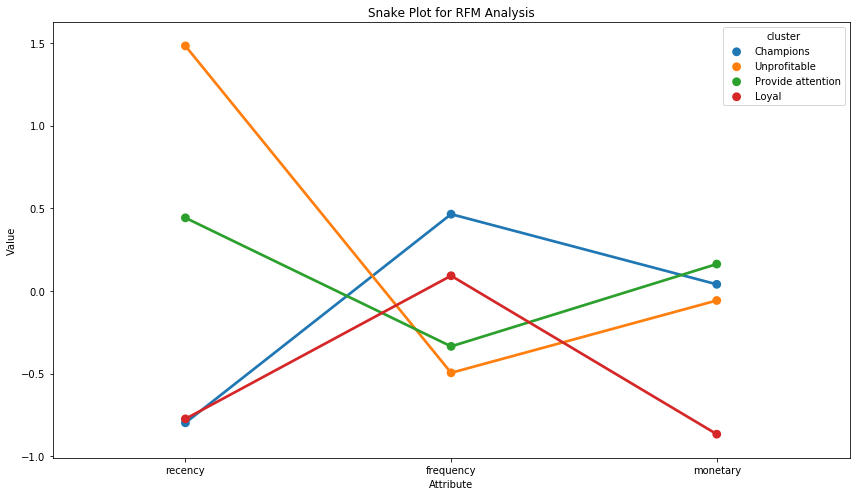

In [44]:
plt.figure(figsize=(12, 7))
plt.title('Snake Plot for RFM Analysis')
plt.xlabel('Attribute')
plt.ylabel('Value')
sns.pointplot(data=df_melt, x='Attribute', y='Value', hue='cluster')

plt.tight_layout()

### 3.3.2 Demographic Analysis of RFM Segments

#### Read in CSV and Conduct Basic Analysis

In [45]:
customers = pd.read_csv('data/customers.csv')
print('Dataframe shape:',customers.shape)
customers.head()

Dataframe shape: (1371980, 7)


,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [46]:
customers = customers.loc[:,['customer_id','Active','club_member_status','fashion_news_frequency','age','postal_code']]
print('Dataframe shape:',customers.shape)
customers.head()

Dataframe shape: (1371980, 6)


,customer_id,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [47]:
# Basic data check: Check for null values
for col in customers.columns:
    print("Number of Null Values in", col, " : ", len(customers[customers[col].isna()]), "/", len(customers))

Number of Null Values in customer_id  :  0 / 1371980
Number of Null Values in Active  :  907576 / 1371980
Number of Null Values in club_member_status  :  6062 / 1371980
Number of Null Values in fashion_news_frequency  :  16009 / 1371980
Number of Null Values in age  :  15861 / 1371980
Number of Null Values in postal_code  :  0 / 1371980


In [48]:
# Handle null values
customers['Active'] = customers['Active'].fillna(0)
customers['club_member_status'] = customers['club_member_status'].fillna('NONE')
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].fillna('None')
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].replace(['NONE'],'None')
customers = customers.dropna(subset=['age'])

# Check for null values
for col in customers.columns:
    print("Number of Null Values in", col, " : ", len(customers[customers[col].isna()]), "/", len(customers))
    
customers.dtypes

Number of Null Values in customer_id  :  0 / 1356119
Number of Null Values in Active  :  0 / 1356119
Number of Null Values in club_member_status  :  0 / 1356119
Number of Null Values in fashion_news_frequency  :  0 / 1356119
Number of Null Values in age  :  0 / 1356119
Number of Null Values in postal_code  :  0 / 1356119


customer_id                object
Active                    float64
club_member_status         object
fashion_news_frequency     object
age                       float64
postal_code                object
dtype: object

In [49]:
# Convert datatypes to suitable datatypes
customers = customers.astype({'customer_id':'str',
                              'Active':'category',
                              'club_member_status':'category',
                              'fashion_news_frequency':'category',
                              'age':'int64',
                              'postal_code':'category'})
customers.dtypes

customer_id                 object
Active                    category
club_member_status        category
fashion_news_frequency    category
age                          int64
postal_code               category
dtype: object

In [50]:
rfm_customers = customers.merge(df_rfm[['customer_id','Recency','Frequency','Monetary','rfm_label']], on='customer_id')
print('Dataframe shape:',rfm_customers.shape)
rfm_customers.head()

Dataframe shape: (1346520, 10)


,customer_id,Active,club_member_status,fashion_news_frequency,age,postal_code,Recency,Frequency,Monetary,rfm_label
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.0,ACTIVE,None,49,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...,26,21,30.903955,Champions
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.0,ACTIVE,None,25,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...,85,86,30.255026,Champions
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.0,ACTIVE,None,24,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,16,18,39.154426,Champions
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.0,ACTIVE,None,54,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...,480,2,30.491525,Unprofitable
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,ACTIVE,Regularly,52,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...,50,13,36.130378,Champions


#### Demographic Analysis 1: Descriptive analysis

#### - Demographic Analysis 1.1: Descriptive analysis by Recency, Frequency and Monetary

In [51]:
rfm_customers.groupby('rfm_label')['Recency', 'Frequency', 'Monetary'].describe()

Recency                                               \
                      count        mean         std    min    25%    50%   
rfm_label                                                                  
Champions          552125.0   67.828782   46.859068    9.0   27.0   57.0   
Loyal              104852.0   73.122496   43.458139    9.0   37.0   67.0   
Provide attention  489448.0  341.247252  175.722076    9.0  217.0  306.0   
Unprofitable       200095.0  571.669837  113.272971  360.0  467.0  587.0   

                                Frequency                                   \
                     75%    max     count       mean        std  min   25%   
rfm_label                                                                    
Champions          100.0  179.0  552125.0  41.691095  51.893487  3.0  11.0   
Loyal              100.0  179.0  104852.0  27.010901  35.803073  3.0   7.0   
Provide attention  462.0  742.0  489448.0  10.229853  15.337484  1.0   2.0   
Unprofitable       675.0  742.0  200095.0   3.949334   6.270264  1.0   1.0   

                                       Monetary                        \
                    50%   75%     max     count       mean        std   
rfm_label                                                               
Champions          25.0  52.0  1895.0  552125.0  29.329819   8.443324   
Loyal              16.0  33.0  1117.0  104852.0  16.379771   2.702356   
Provide attention   5.0  12.0   901.0  489448.0  31.070159  15.601015   
Unprofitable        2.0   4.0   380.0  200095.0  27.846716  21.741927   

                                                                           
                         min        25%        50%        75%         max  
rfm_label                                                                  
Champions          19.616550  23.746533  27.478343  32.569516  337.288136  
Loyal               1.474576  14.933008  17.046292  18.503556   19.616447  
Provide attention   0.762712  22.440678  27.799601  35.281452  422.033898  
Unprofitable        0.847458  15.237288  19.474576  33.881356  506.779661

#### - Demographic Analysis 1.2: Descriptive analysis by customers demographics

In [52]:
rfm_customers.groupby('rfm_label')['Active','club_member_status','fashion_news_frequency','age','postal_code'].describe()

age                                                \
                      count       mean        std   min   25%   50%   75%   
rfm_label                                                                   
Champions          552125.0  35.705831  13.877447  16.0  24.0  30.0  48.0   
Loyal              104852.0  32.772155  13.204990  16.0  22.0  28.0  43.0   
Provide attention  489448.0  37.260641  14.642318  16.0  25.0  33.0  50.0   
Unprofitable       200095.0  38.084295  14.741217  16.0  25.0  35.0  50.0   

                         
                    max  
rfm_label                
Champions          99.0  
Loyal              99.0  
Provide attention  99.0  
Unprofitable       99.0

#### Demographic Analysis 2: Graphic analysis for the different RFM segments (Bottom 2 analyses are the same just displayed in different sequences)

In [53]:
def countplot(df, var_col, xticklabels, rotate=False):
    plt.figure(figsize=(12,5))
    ax = sns.countplot(x=var_col, data=df)
    ax.set(xlabel=var_col, ylabel='Count')
    for p in ax.patches:
        ax.annotate(p.get_height(), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', 
                    va='center', 
                    xytext=(0, 10), 
                    textcoords='offset points')

    ax.set_xticklabels(xticklabels)
    if rotate:
        plt.xticks(rotation=45)

    max_height = max([x.get_height() for x in ax.patches])    
    plt.ylim(0, max_height*1.25)
    plt.title(f'Distribution of {var_col}')
    plt.show()

#### - Demographic Analysis 2.1: View graphs by RFM Segments (Compare within RFM Segments)

In [54]:
# labels = list(rfm_customers['rfm_label'].unique())
# for label in labels:
#     print('----- RFM Segment:',label,'-----')
#     subset_df = rfm_customers[rfm_customers['rfm_label']==label]
#     for col in ['Active','club_member_status','fashion_news_frequency','age']:
#         print('Plotting countplot...')
#         print('RFM Segment:',label)
#         print('Variable:',col)
#         if col=='age':
#             sorted_x = list(subset_df[col].unique())
#             sorted_x.sort()
#             countplot(subset_df, col, sorted_x, rotate=True)
#         else:
#             countplot(subset_df, col, list(subset_df[col].unique()))

#### - Demographic Analysis 2.2: View graphs by Variables (Compare across RFM Segments)

Demographic Analysis 2.2.1: Using bar charts

----- Variable: Active -----
Plotting countplot...
Variable: Active
RFM Segment: Champions


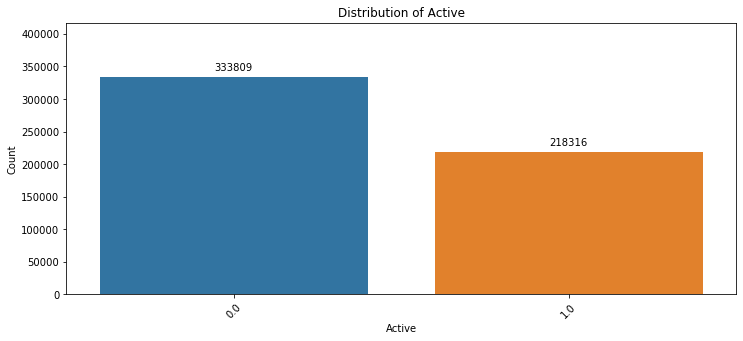

Plotting countplot...
Variable: Active
RFM Segment: Unprofitable


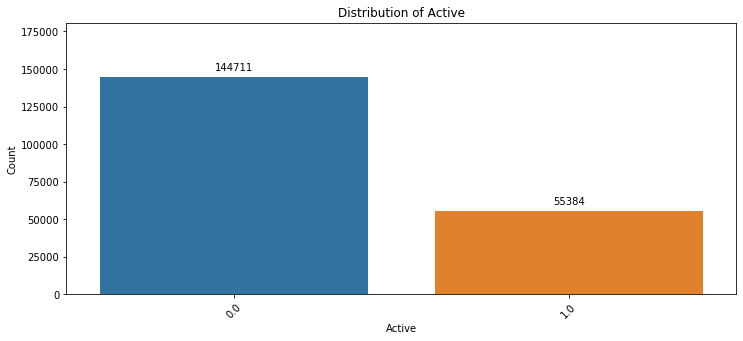

Plotting countplot...
Variable: Active
RFM Segment: Provide attention


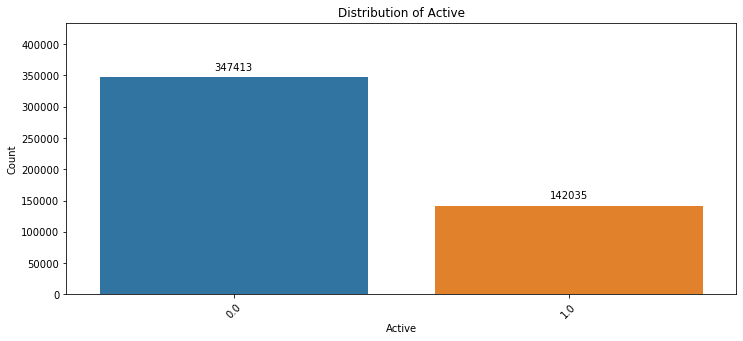

Plotting countplot...
Variable: Active
RFM Segment: Loyal


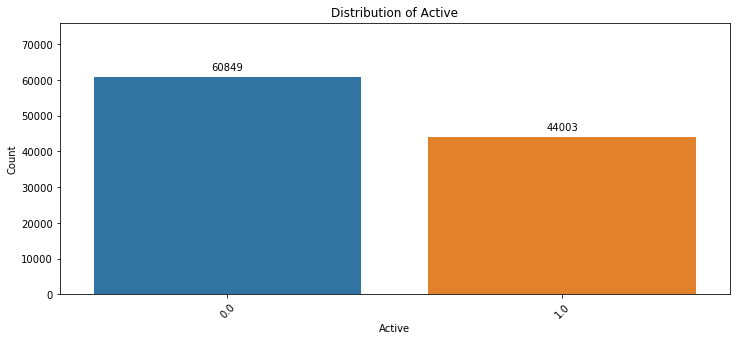

----- Variable: club_member_status -----
Plotting countplot...
Variable: club_member_status
RFM Segment: Champions


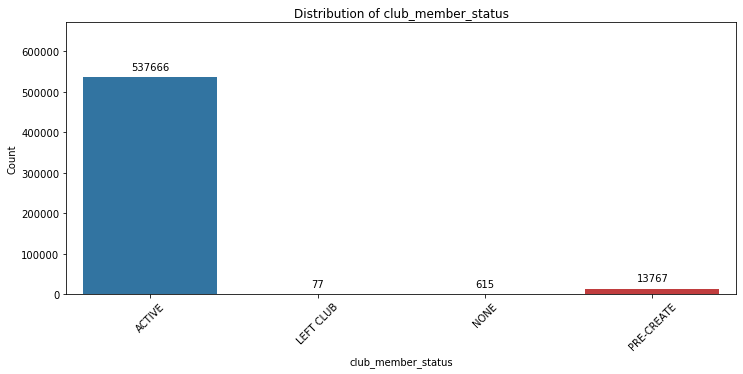

Plotting countplot...
Variable: club_member_status
RFM Segment: Unprofitable


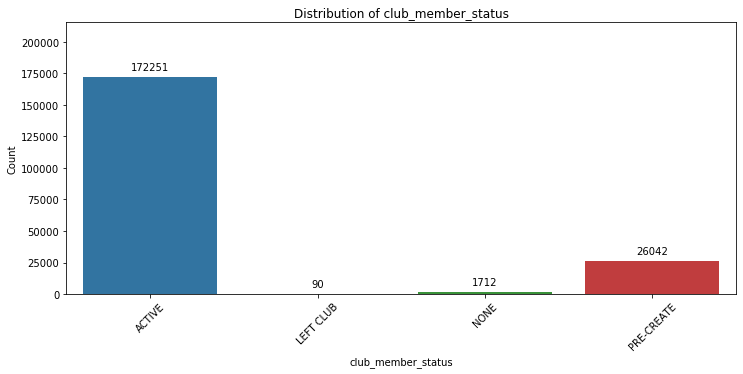

Plotting countplot...
Variable: club_member_status
RFM Segment: Provide attention


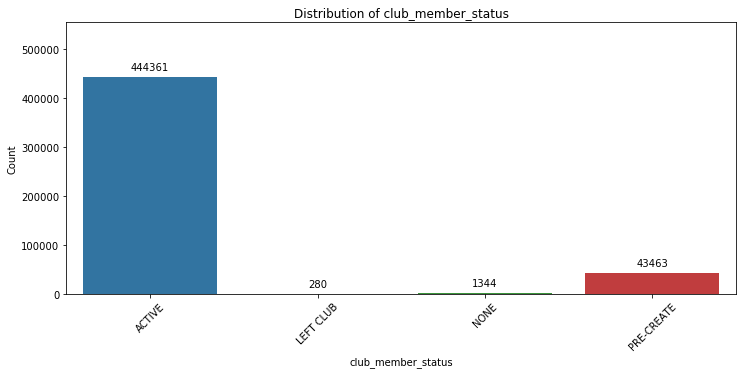

Plotting countplot...
Variable: club_member_status
RFM Segment: Loyal


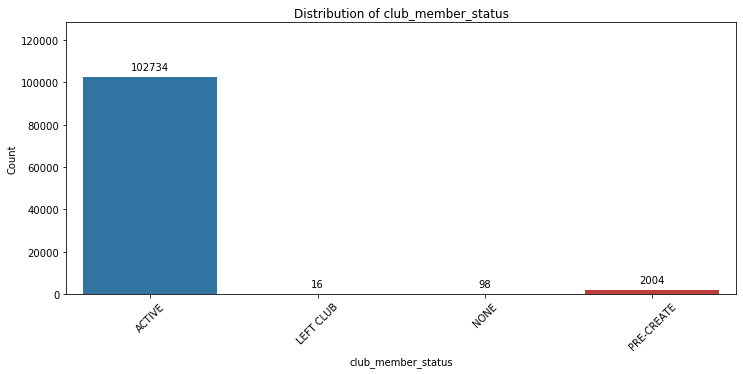

----- Variable: fashion_news_frequency -----
Plotting countplot...
Variable: fashion_news_frequency
RFM Segment: Champions


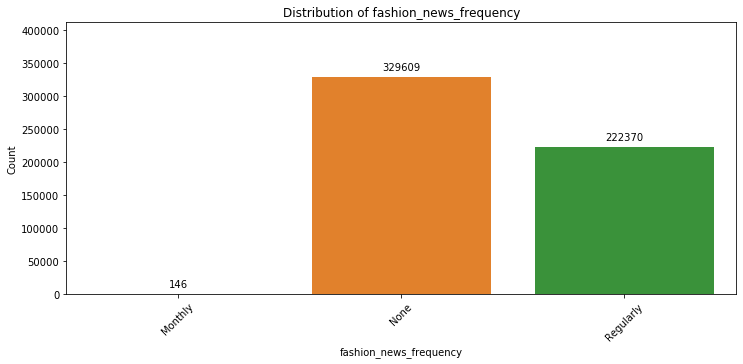

Plotting countplot...
Variable: fashion_news_frequency
RFM Segment: Unprofitable


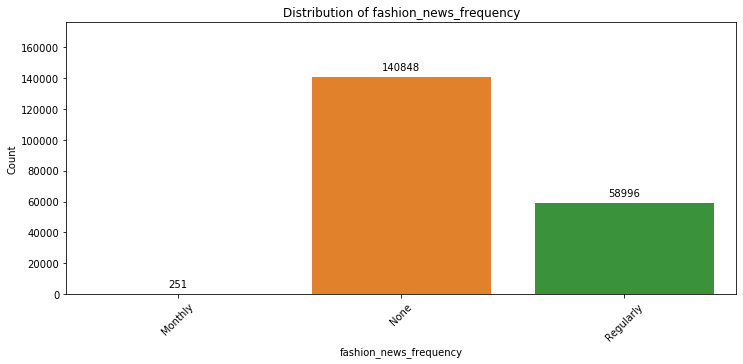

Plotting countplot...
Variable: fashion_news_frequency
RFM Segment: Provide attention


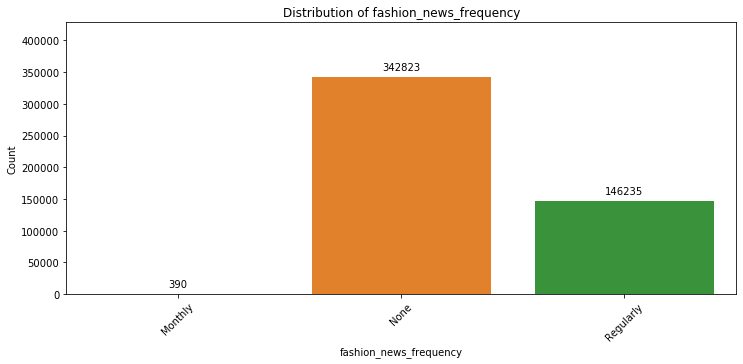

Plotting countplot...
Variable: fashion_news_frequency
RFM Segment: Loyal


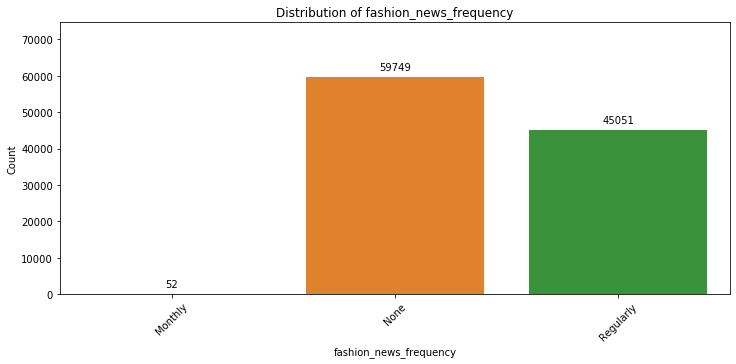

----- Variable: age -----
Plotting countplot...
Variable: age
RFM Segment: Champions


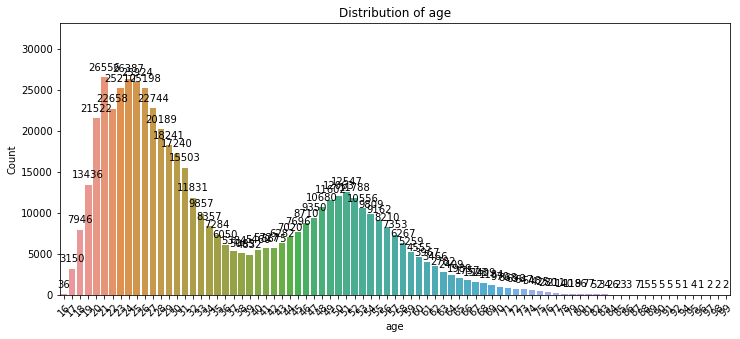

Plotting countplot...
Variable: age
RFM Segment: Unprofitable


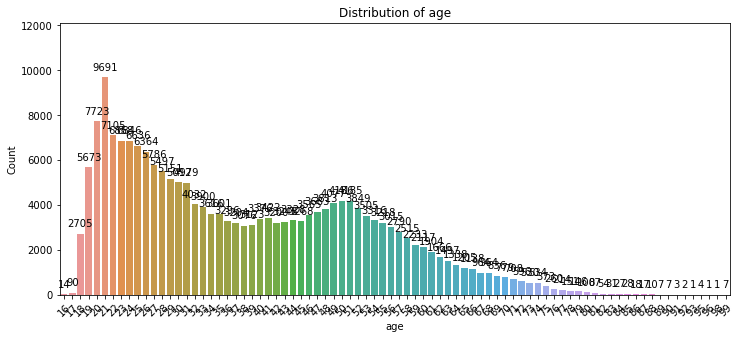

Plotting countplot...
Variable: age
RFM Segment: Provide attention


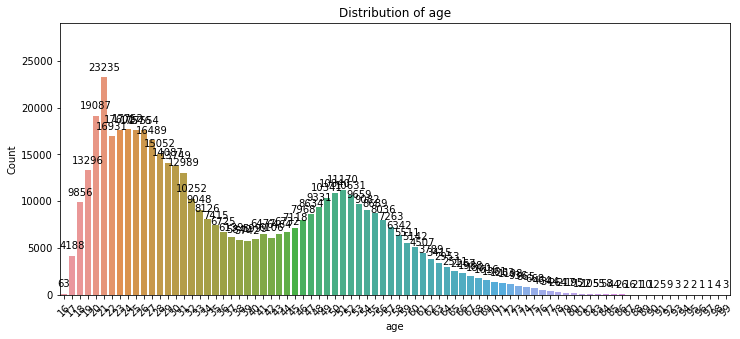

Plotting countplot...
Variable: age
RFM Segment: Loyal


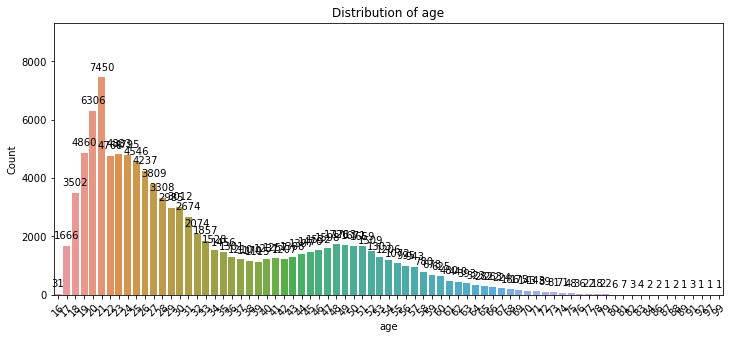

In [55]:
labels = list(rfm_customers['rfm_label'].unique())
for col in ['Active','club_member_status','fashion_news_frequency','age']:
    print('----- Variable:',col,'-----')
    for label in labels:
        subset_df = rfm_customers[rfm_customers['rfm_label']==label]
        print('Plotting countplot...')
        print('Variable:',col)
        print('RFM Segment:',label)
        sorted_x = list(subset_df[col].unique())
        sorted_x.sort()
        countplot(subset_df, col, sorted_x, rotate=True)

Demographic Analysis 2.2.2: Using pie charts (to better see the proportion) *excluded age variable here

----- Variable: Active -----


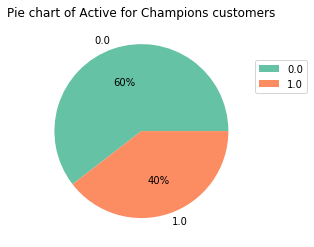

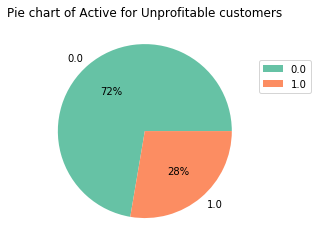

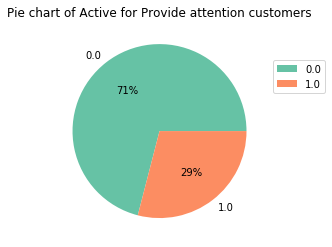

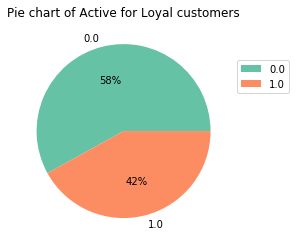

----- Variable: club_member_status -----


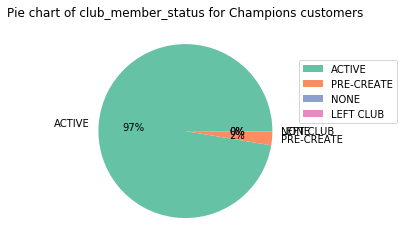

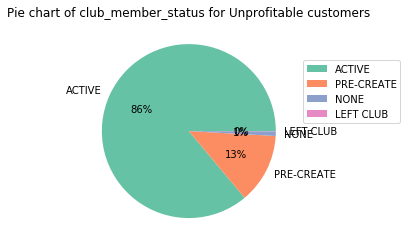

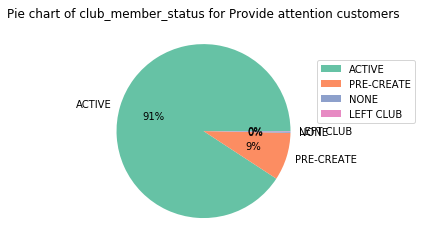

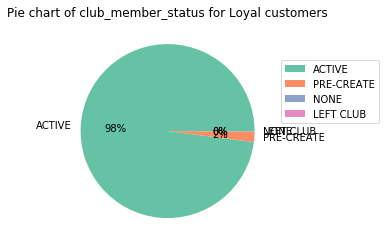

----- Variable: fashion_news_frequency -----


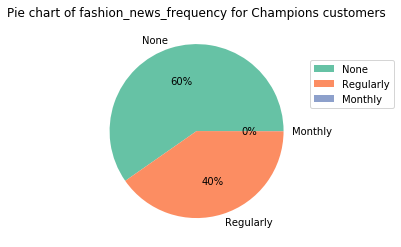

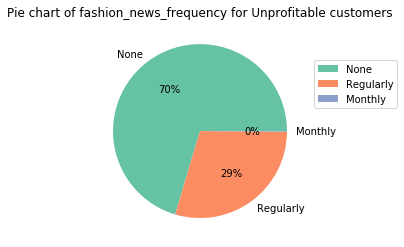

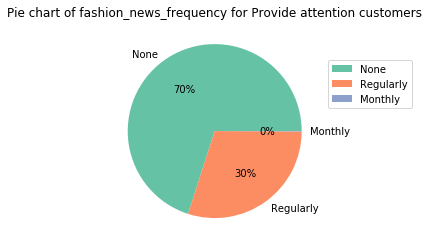

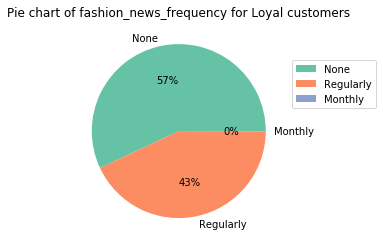

In [56]:
labels = list(rfm_customers['rfm_label'].unique())
for col in ['Active','club_member_status','fashion_news_frequency']:
    print('----- Variable:',col,'-----')
    for label in labels:
        subset_df = rfm_customers[rfm_customers['rfm_label']==label]
        colors = sns.color_palette('Set2')
        plt.pie(subset_df[col].value_counts(), labels=list(subset_df[col].unique()), colors=colors, autopct='%.0f%%')
        plt.title(f'Pie chart of {col} for {label} customers' )
        plt.legend(subset_df[col].value_counts().index, bbox_to_anchor = (1, 0.85))
        plt.show()

### 3.3.3 Comparing Demographics Across Variables

In [57]:
# Find number of unique values in each column
for col in customers.columns[1:]:
    print('Number of unique values in ' + col + ': ' + str(len(customers[col].unique())) + ' / ' + str(len(customers)))

Number of unique values in Active: 2 / 1356119
Number of unique values in club_member_status: 4 / 1356119
Number of unique values in fashion_news_frequency: 3 / 1356119
Number of unique values in age: 84 / 1356119
Number of unique values in postal_code: 351826 / 1356119


#### Age vs Columns

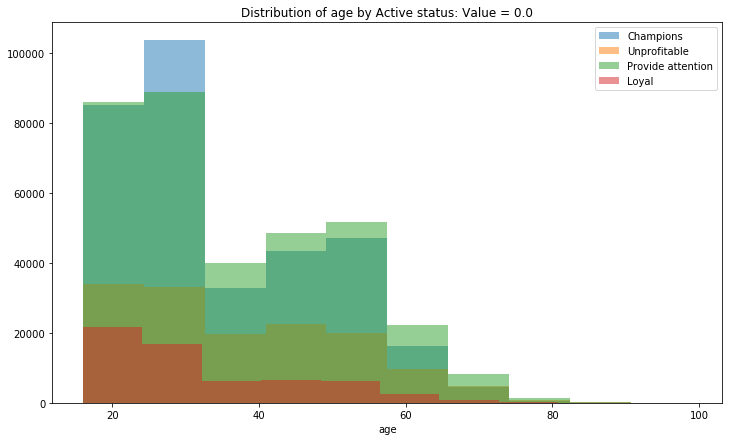

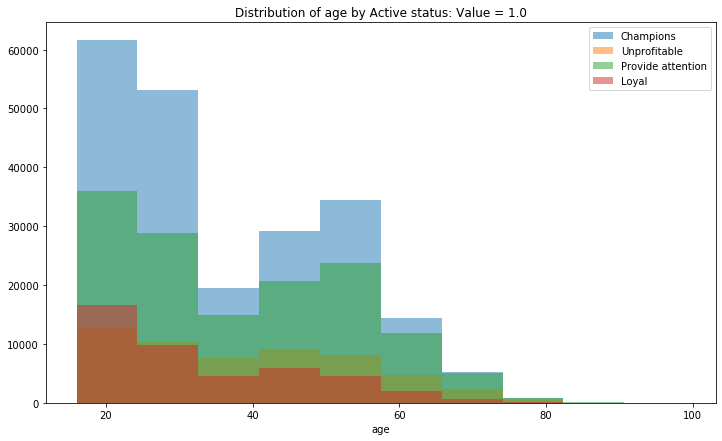

In [58]:
# For Active column
common_col = 'age'
col = 'Active'
for unique_item in rfm_customers[col].unique():
    plt.figure(figsize=(12,7))
    subset_by_item_df = rfm_customers[rfm_customers[col]==unique_item]
    
    for label in rfm_customers['rfm_label'].unique():
        subset_df = subset_by_item_df[subset_by_item_df['rfm_label']==label]
        plt.hist(common_col, data=subset_df, alpha=0.5, label=label)
    plt.title(f'Distribution of {common_col} by {col} status: Value = {unique_item}')
    plt.xlabel(f'{common_col}')
    plt.legend(bbox_to_anchor = (1, 1), loc='upper right')
    plt.show()

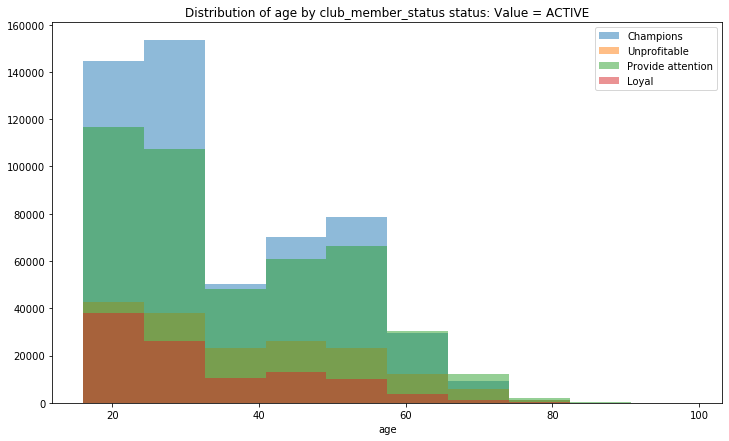

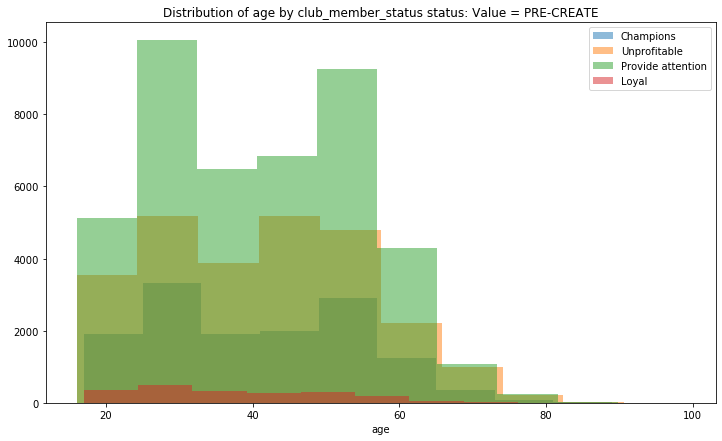

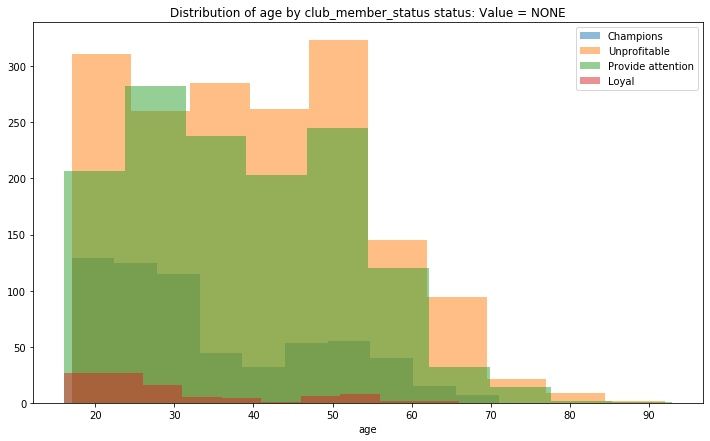

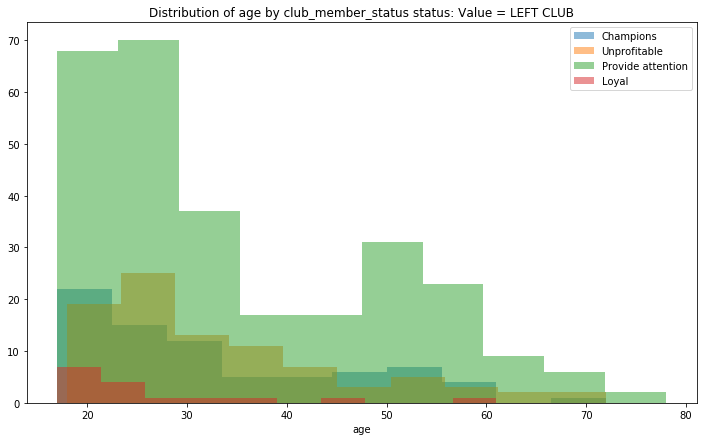

In [59]:
# For club_member_status column
common_col = 'age'
col = 'club_member_status'
for unique_item in rfm_customers[col].unique():
    plt.figure(figsize=(12,7))
    subset_by_item_df = rfm_customers[rfm_customers[col]==unique_item]
    
    for label in rfm_customers['rfm_label'].unique():
        subset_df = subset_by_item_df[subset_by_item_df['rfm_label']==label]
        plt.hist(common_col, data=subset_df, alpha=0.5, label=label)
    plt.title(f'Distribution of {common_col} by {col} status: Value = {unique_item}')
    plt.xlabel(f'{common_col}')
    plt.legend(bbox_to_anchor = (1, 1), loc='upper right')
    plt.show()

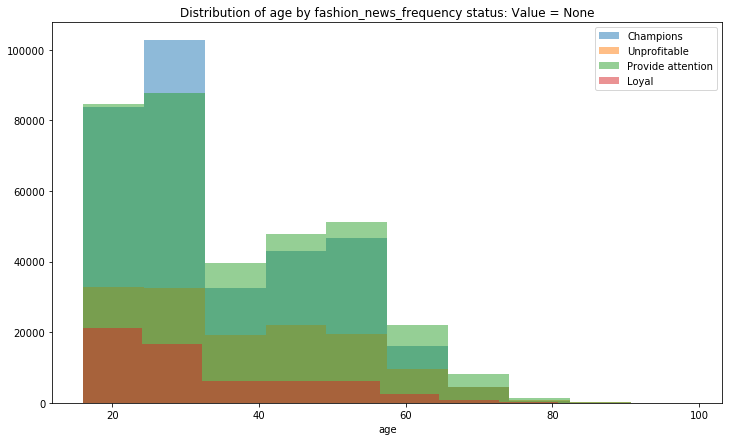

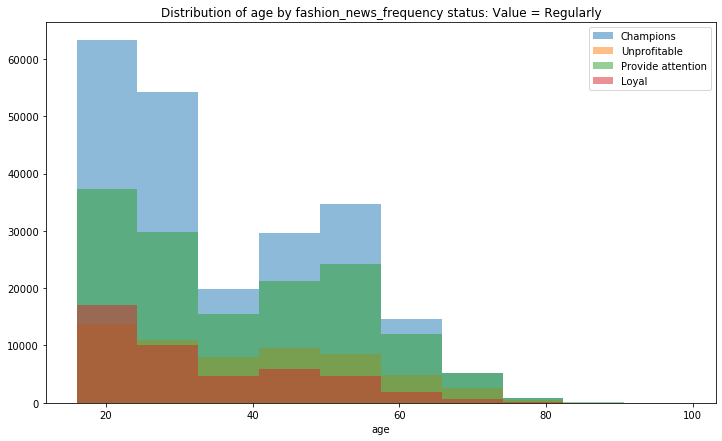

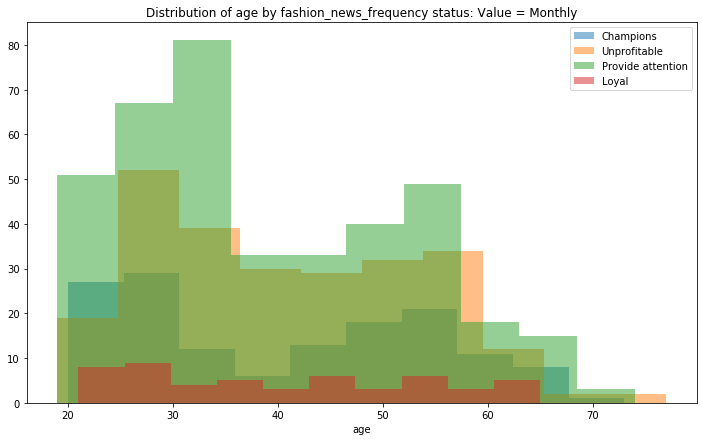

In [60]:
# For fashion_news_frequency column
common_col = 'age'
col = 'fashion_news_frequency'
for unique_item in rfm_customers[col].unique():
    plt.figure(figsize=(12,7))
    subset_by_item_df = rfm_customers[rfm_customers[col]==unique_item]
    
    for label in rfm_customers['rfm_label'].unique():
        subset_df = subset_by_item_df[subset_by_item_df['rfm_label']==label]
        plt.hist(common_col, data=subset_df, alpha=0.5, label=label)
    plt.title(f'Distribution of {common_col} by {col} status: Value = {unique_item}')
    plt.xlabel(f'{common_col}')
    plt.legend(bbox_to_anchor = (1, 1), loc='upper right')
    plt.show()

#### Active vs Columns

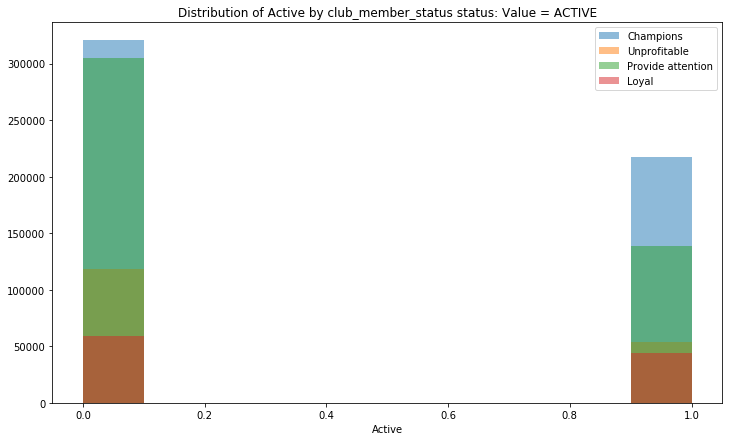

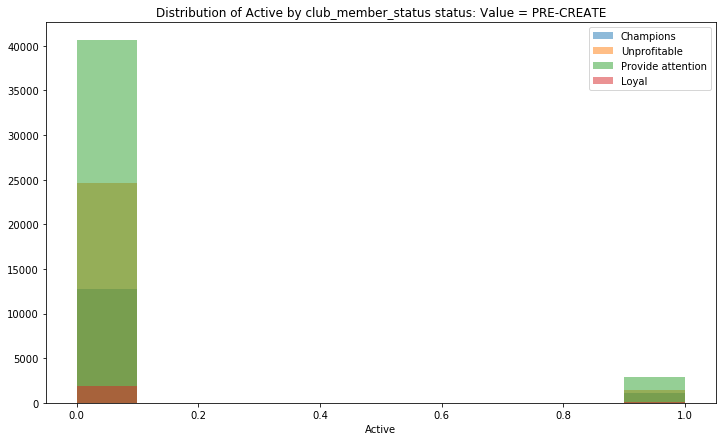

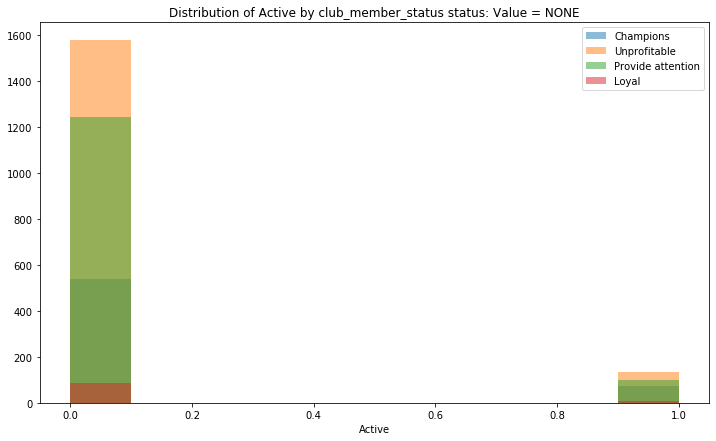

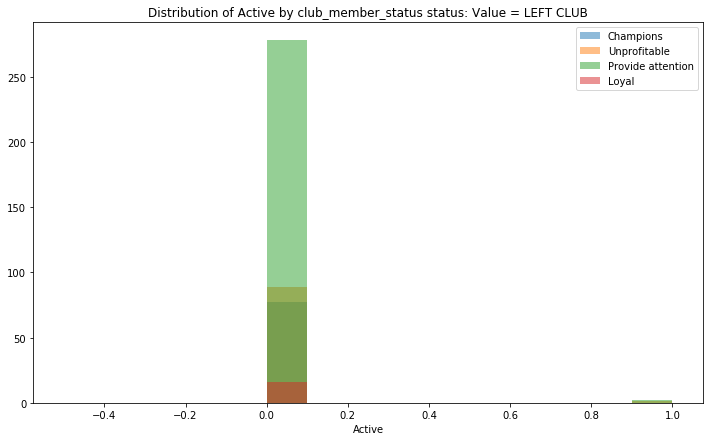

In [61]:
# For age column
common_col = 'Active'
col = 'club_member_status'
for unique_item in rfm_customers[col].unique():
    plt.figure(figsize=(12,7))
    subset_by_item_df = rfm_customers[rfm_customers[col]==unique_item]
    
    for label in rfm_customers['rfm_label'].unique():
        subset_df = subset_by_item_df[subset_by_item_df['rfm_label']==label]
        plt.hist(common_col, data=subset_df, alpha=0.5, label=label)
    plt.title(f'Distribution of {common_col} by {col} status: Value = {unique_item}')
    plt.xlabel(f'{common_col}')
    plt.legend(bbox_to_anchor = (1, 1), loc='upper right')
    plt.show()

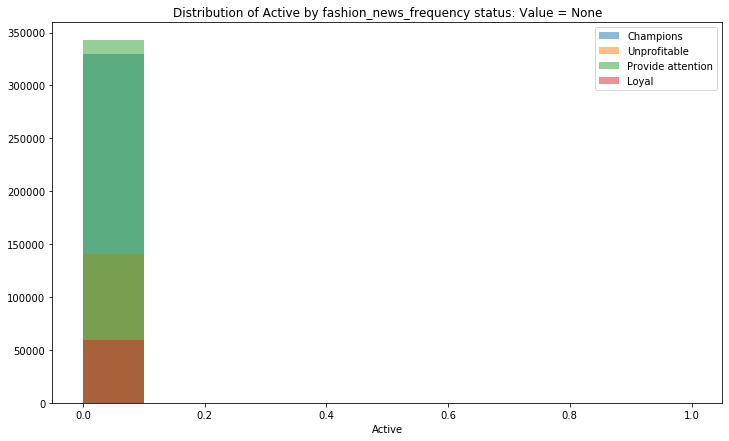

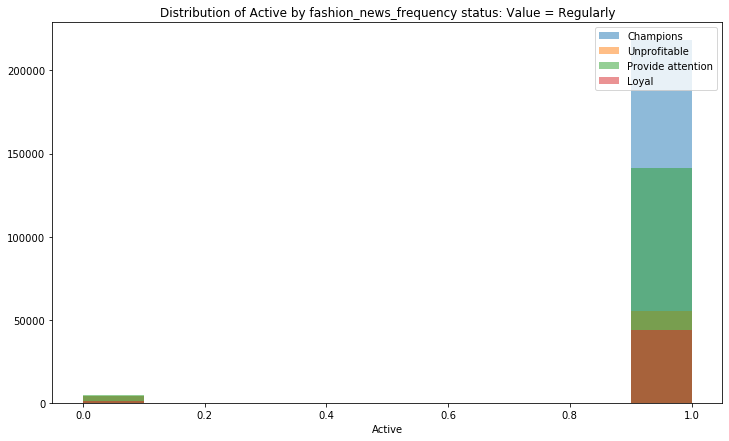

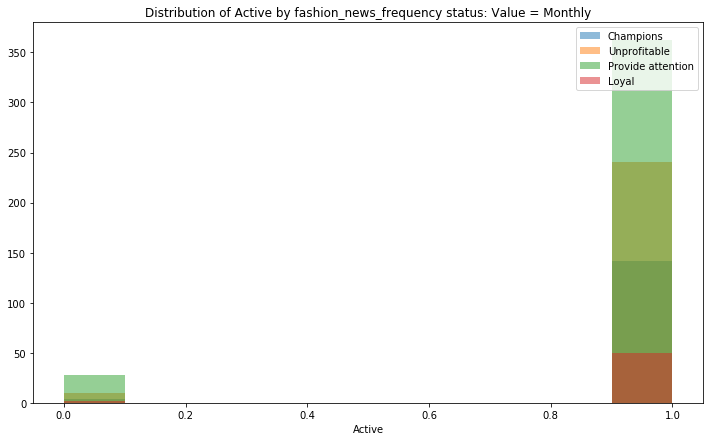

In [62]:
# For age column
common_col = 'Active'
col = 'fashion_news_frequency'
for unique_item in rfm_customers[col].unique():
    plt.figure(figsize=(12,7))
    subset_by_item_df = rfm_customers[rfm_customers[col]==unique_item]
    
    for label in rfm_customers['rfm_label'].unique():
        subset_df = subset_by_item_df[subset_by_item_df['rfm_label']==label]
        plt.hist(common_col, data=subset_df, alpha=0.5, label=label)
    plt.title(f'Distribution of {common_col} by {col} status: Value = {unique_item}')
    plt.xlabel(f'{common_col}')
    plt.legend(bbox_to_anchor = (1, 1), loc='upper right')
    plt.show()

#### fashion_news_frequency vs club_member_status

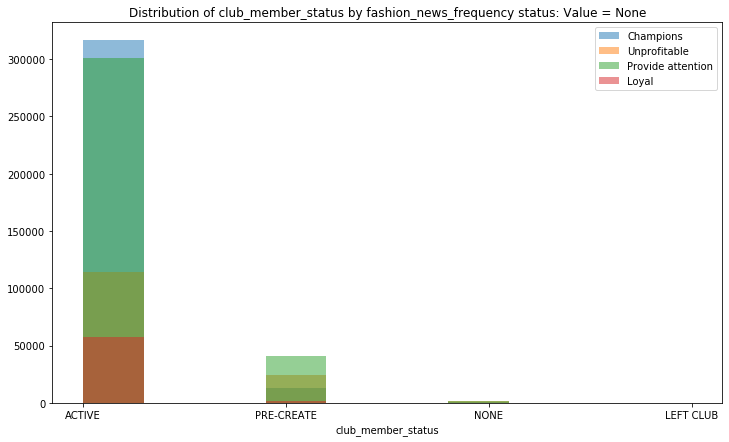

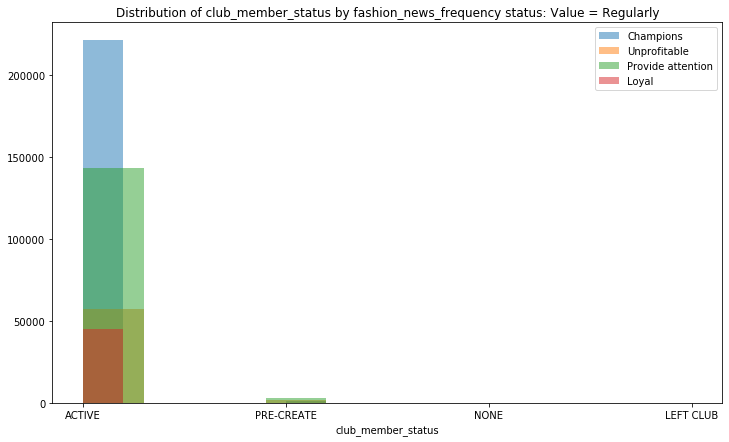

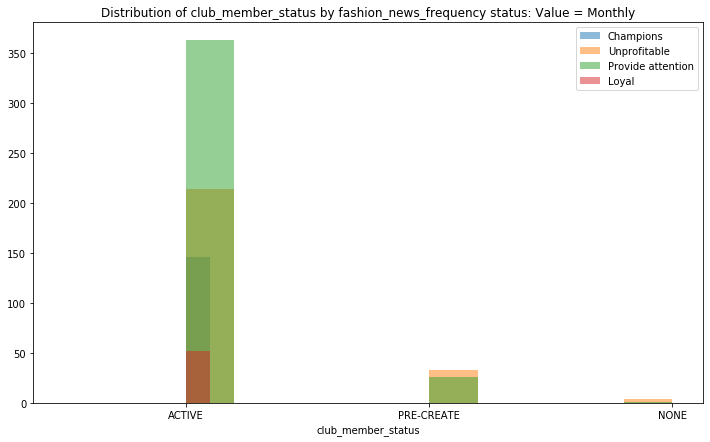

In [63]:
# For age column
common_col = 'club_member_status'
col = 'fashion_news_frequency'
for unique_item in rfm_customers[col].unique():
    plt.figure(figsize=(12,7))
    subset_by_item_df = rfm_customers[rfm_customers[col]==unique_item]
    
    for label in rfm_customers['rfm_label'].unique():
        subset_df = subset_by_item_df[subset_by_item_df['rfm_label']==label]
        plt.hist(common_col, data=subset_df, alpha=0.5, label=label)
    plt.title(f'Distribution of {common_col} by {col} status: Value = {unique_item}')
    plt.xlabel(f'{common_col}')
    plt.legend(bbox_to_anchor = (1, 1), loc='upper right')
    plt.show()

### 3.3.4 Purchase Behaviour Analysis of RFM Segments (with Transactions Data)

#### Read in CSV and Conduct Basic Analysis

In [64]:
articles = pd.read_csv('data/articles.csv')
print('Dataframe shape:',articles.shape)
articles.head()

Dataframe shape: (105542, 25)


,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,Dusty Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,4,Dark,5,Black,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,3,Light,9,White,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [65]:
articles = articles.loc[:,['article_id','prod_name','product_type_name','product_group_name',
                          'graphical_appearance_name','colour_group_name','perceived_colour_value_name',
                          'perceived_colour_master_name','department_name','index_name','index_group_name',
                          'section_name','garment_group_name']]
print('Dataframe shape:',articles.shape)
articles.head()

Dataframe shape: (105542, 13)


,article_id,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name
0,108775015,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic
1,108775044,Strap top,Vest top,Garment Upper body,Solid,White,Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic
2,108775051,Strap top (1),Vest top,Garment Upper body,Stripe,Off White,Dusty Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic
3,110065001,OP T-shirt (Idro),Bra,Underwear,Solid,Black,Dark,Black,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear"
4,110065002,OP T-shirt (Idro),Bra,Underwear,Solid,White,Light,White,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear"


In [66]:
# Basic data check: Check for null values
for col in articles.columns:
    print("Number of Null Values in", col, " : ", len(articles[articles[col].isna()]), "/", len(articles))

Number of Null Values in article_id  :  0 / 105542
Number of Null Values in prod_name  :  0 / 105542
Number of Null Values in product_type_name  :  0 / 105542
Number of Null Values in product_group_name  :  0 / 105542
Number of Null Values in graphical_appearance_name  :  0 / 105542
Number of Null Values in colour_group_name  :  0 / 105542
Number of Null Values in perceived_colour_value_name  :  0 / 105542
Number of Null Values in perceived_colour_master_name  :  0 / 105542
Number of Null Values in department_name  :  0 / 105542
Number of Null Values in index_name  :  0 / 105542
Number of Null Values in index_group_name  :  0 / 105542
Number of Null Values in section_name  :  0 / 105542
Number of Null Values in garment_group_name  :  0 / 105542


In [67]:
# Convert datatypes to suitable datatypes
articles = articles.astype({'article_id':'str',
                            'prod_name':'category',
                            'product_type_name':'category',
                            'product_group_name':'category',
                            'graphical_appearance_name':'category',
                            'colour_group_name':'category',
                            'perceived_colour_value_name':'category',
                            'perceived_colour_master_name':'category',
                            'department_name':'category',
                            'index_name':'category',
                            'index_group_name':'category',
                            'section_name':'category',
                            'garment_group_name':'category'})
articles.dtypes

article_id                        object
prod_name                       category
product_type_name               category
product_group_name              category
graphical_appearance_name       category
colour_group_name               category
perceived_colour_value_name     category
perceived_colour_master_name    category
department_name                 category
index_name                      category
index_group_name                category
section_name                    category
garment_group_name              category
dtype: object

In [68]:
# Merge Articles with Transaction Data on article_id (Transations data is df_new subsetted at the start)
article_transaction = articles.merge(df_new, on='article_id')

# Merge Article+Transaction with RFM Data on customer_id
rfm_article_transact = article_transaction.merge(df_rfm[['customer_id','Recency','Frequency','Monetary','rfm_label']], on='customer_id')

print('Dataframe shape:',rfm_article_transact.shape)
rfm_article_transact.head()

Dataframe shape: (31788324, 21)


,article_id,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name,customer_id,t_dat,price,sales_channel_id,Recency,Frequency,Monetary,rfm_label
0,108775015,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,05ed96931b707698bc94aa53766d44686ae5ccbbc99dfb...,2018-09-20,0.008458,1,14,89,26.005904,Champions
1,108775015,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,05ed96931b707698bc94aa53766d44686ae5ccbbc99dfb...,2018-09-20,0.008458,1,14,89,26.005904,Champions
2,108775015,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,05ed96931b707698bc94aa53766d44686ae5ccbbc99dfb...,2018-12-04,0.008458,1,14,89,26.005904,Champions
3,237347040,Theron,Hoodie,Garment Upper body,Melange,Light Blue,Light,Blue,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,05ed96931b707698bc94aa53766d44686ae5ccbbc99dfb...,2019-04-08,0.033881,1,14,89,26.005904,Champions
4,270381001,Clubba sunglasses,Sunglasses,Accessories,Solid,Yellowish Brown,Dark,Brown,Sunglasses,Ladies Accessories,Ladieswear,Womens Small accessories,Accessories,05ed96931b707698bc94aa53766d44686ae5ccbbc99dfb...,2019-07-12,0.006763,1,14,89,26.005904,Champions


#### Remove irrelevant columns and put customer_id to the front of the dataframe

In [69]:
# Drop columns that are not needed
rfm_article_transact = rfm_article_transact.drop(['article_id','t_dat','Recency','Frequency','Monetary'], axis=1)

# Place customer_id in the 1st column
customer_id = rfm_article_transact['customer_id']
rfm_article_transact.drop(labels=['customer_id'], axis=1, inplace=True)
rfm_article_transact.insert(0, 'customer_id', customer_id)

rfm_article_transact.head()

,customer_id,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name,price,sales_channel_id,rfm_label
0,05ed96931b707698bc94aa53766d44686ae5ccbbc99dfb...,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,0.008458,1,Champions
1,05ed96931b707698bc94aa53766d44686ae5ccbbc99dfb...,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,0.008458,1,Champions
2,05ed96931b707698bc94aa53766d44686ae5ccbbc99dfb...,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,0.008458,1,Champions
3,05ed96931b707698bc94aa53766d44686ae5ccbbc99dfb...,Theron,Hoodie,Garment Upper body,Melange,Light Blue,Light,Blue,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,0.033881,1,Champions
4,05ed96931b707698bc94aa53766d44686ae5ccbbc99dfb...,Clubba sunglasses,Sunglasses,Accessories,Solid,Yellowish Brown,Dark,Brown,Sunglasses,Ladies Accessories,Ladieswear,Womens Small accessories,Accessories,0.006763,1,Champions


#### Purchase Behaviour Analysis 1: Descriptive analysis

In [70]:
rfm_article_transact.groupby('rfm_label')['prod_name','product_type_name','graphical_appearance_name','colour_group_name',
               'perceived_colour_value_name','perceived_colour_master_name','department_name',
               'index_name','index_group_name','section_name','garment_group_name','sales_channel_id'].describe()

prod_name                                           \
                      count unique                       top    freq   
rfm_label                                                              
Champions          23085215  44346  Jade HW Skinny Denim TRS  129218   
Loyal               2845475  36482                 Tilly (1)   18973   
Provide attention   5051930  38748  Jade HW Skinny Denim TRS   29320   
Unprofitable         805704  24516                 Tilly (1)    3971   

                  product_type_name                            \
                              count unique       top     freq   
rfm_label                                                       
Champions                  23085215    130  Trousers  3136123   
Loyal                       2845475    128   T-shirt   302974   
Provide attention           5051930    126  Trousers   723898   
Unprofitable                 805704    110   T-shirt    88678   

                  graphical_appearance_name                          \
                                      count unique    top      freq   
rfm_label                                                             
Champions                          23085215     30  Solid  13140692   
Loyal                               2845475     30  Solid   1563796   
Provide attention                   5051930     30  Solid   2744117   
Unprofitable                         805704     29  Solid    401326   

                  colour_group_name                         \
                              count unique    top     freq   
rfm_label                                                    
Champions                  23085215     50  Black  8041432   
Loyal                       2845475     50  Black   934098   
Provide attention           5051930     50  Black  1811220   
Unprofitable                 805704     50  Black   250206   

                  perceived_colour_value_name                         \
                                        count unique   top      freq   
rfm_label                                                              
Champions                            23085215      8  Dark  11242320   
Loyal                                 2845475      8  Dark   1319572   
Provide attention                     5051930      8  Dark   2637956   
Unprofitable                           805704      8  Dark    389715   

                  perceived_colour_master_name                         \
                                         count unique    top     freq   
rfm_label                                                               
Champions                             23085215     20  Black  7991880   
Loyal                                  2845475     20  Black   927903   
Provide attention                      5051930     20  Black  1795167   
Unprofitable                            805704     19  Black   247145   

                  department_name                           index_name         \
                            count unique       top     freq      count unique   
rfm_label                                                                       
Champions                23085215    249  Swimwear  1846943   23085215     10   
Loyal                     2845475    245  Swimwear   222206    2845475     10   
Provide attention         5051930    249  Swimwear   367430    5051930     10   
Unprofitable               805704    239  Swimwear    58543     805704     10   

                                       index_group_name                     \
                          top     freq            count unique         top   
rfm_label                                                                    
Champions          Ladieswear  9879535         23085215      5  Ladieswear   
Loyal              Ladieswear   918357          2845475      5  Ladieswear   
Provide attention  Ladieswear  2029579          5051930      5  Ladieswear   
Unprofitable       Ladieswear   230812           805704      5  Ladiesw

#### Purchase Behaviour Analysis 2: Analysis of purchase behaviour by segments (Bottom 2 analyses are the same just displayed in different sequences)

#### - Purchase Behaviour Analysis 2.1: Compare purchase behaviour within RFM segments (Same as Graphical Analysis but in number form)

In [71]:
# # Based on Top 10 categories in each column variable
# labels = list(rfm_article_transact['rfm_label'].unique())
# for label in labels:
#     print('----- RFM Segment:',label,'-----')
#     subset_df = rfm_article_transact[rfm_article_transact['rfm_label']==label]
#     for col in ['prod_name','product_type_name','graphical_appearance_name','colour_group_name',
#                'perceived_colour_value_name','perceived_colour_master_name','department_name',
#                'index_name','index_group_name','section_name','garment_group_name','sales_channel_id']:
#         print('Column:',col)
#         value_counts = subset_df[col].value_counts().loc[lambda x: x>0]
#         if len(value_counts) > 10:
#             print(value_counts[:10])
#         else:
#             print(value_counts)
#         print('\n')

#### - Purchase Behaviour Analysis 2.2: Compare purchase behaviour across RFM segments (Same as Graphical Analysis but in number form)

In [72]:
# # Based on Top 10 categories in each column variable
# labels = list(rfm_article_transact['rfm_label'].unique())
# for col in ['prod_name','product_type_name','graphical_appearance_name','colour_group_name',
#                'perceived_colour_value_name','perceived_colour_master_name','department_name',
#                'index_name','index_group_name','section_name','garment_group_name','sales_channel_id']:
#     print('----- Column:',col,'-----')
#     for label in labels:
#         print('RFM Segment:',label)
#         subset_df = rfm_article_transact[rfm_article_transact['rfm_label']==label]
#         value_counts = subset_df[col].value_counts().loc[lambda x: x>0]
#         if len(value_counts) > 10:
#             print(value_counts[:10])
#         else:
#             print(value_counts)
#         print('\n')

#### Purchase Behaviour Analysis 3: Graphical Analysis for the different RFM Segments (Bottom 2 analyses are the same just displayed in different sequences)

In [73]:
def barplot(df, segment, var_col, xticklabels, rotate=False):
    fig, ax = plt.subplots(figsize=(15,7))
    plt.bar(xticklabels, df[var_col])
    for p in ax.patches:
        ax.annotate(p.get_height(), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', 
                    va='center', 
                    xytext=(0, 10), 
                    textcoords='offset points')

    ax.set_xticklabels(xticklabels)
    if rotate:
        plt.xticks(rotation=45)

    max_height = max([x.get_height() for x in ax.patches])    
    plt.ylim(0, max_height*1.25)
    plt.title(f'Bar chart of {var_col} for {segment}')
    plt.show()

#### - Purchase Behaviour Analysis 3.1: View graphs by RFM Segments (Compare within RFM Segments) [Based on Top 10 categories]

In [74]:
# # Based on Top 10 categories in each column variable
# labels = list(rfm_article_transact['rfm_label'].unique())
# for label in labels:
#     print('----- RFM Segment:',label,'-----')
#     subset_df = rfm_article_transact[rfm_article_transact['rfm_label']==label]
#     for col in ['prod_name','product_type_name','graphical_appearance_name','colour_group_name',
#                'perceived_colour_value_name','perceived_colour_master_name','department_name',
#                'index_name','index_group_name','section_name','garment_group_name','sales_channel_id']:
#         print('Column:',col)
#         value_counts = subset_df[col].value_counts().loc[lambda x: x>0].to_frame()
#         if len(value_counts) > 10:
#             value_counts = value_counts[:10]
#         barplot(value_counts, label, col, value_counts.index, rotate=True)
#         print('\n')

#### - Purchase Behaviour Analysis 3.2: View graphs by Variables (Compare across RFM Segments)

----- Variable: prod_name -----
RFM Segment: Champions


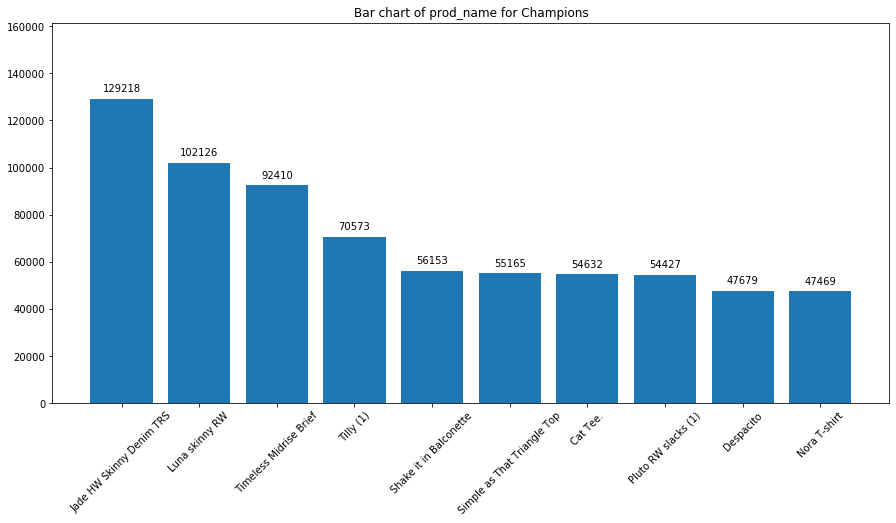



RFM Segment: Provide attention


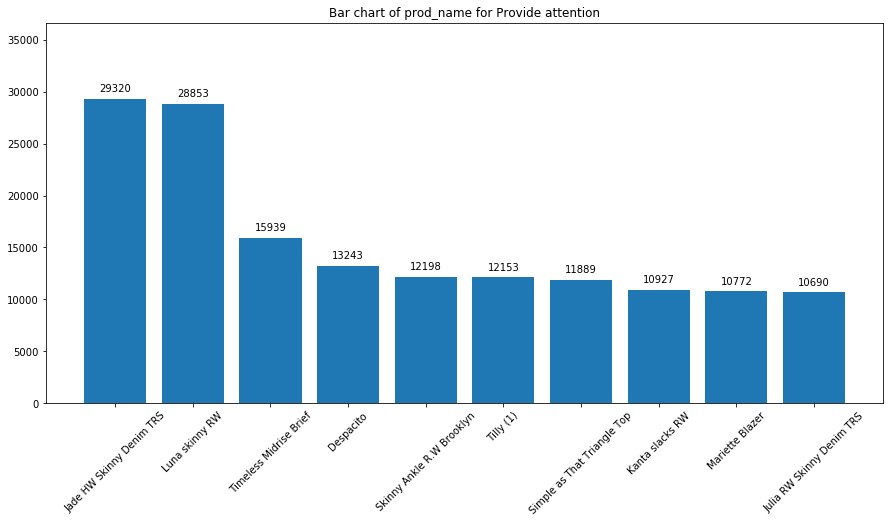



RFM Segment: Loyal


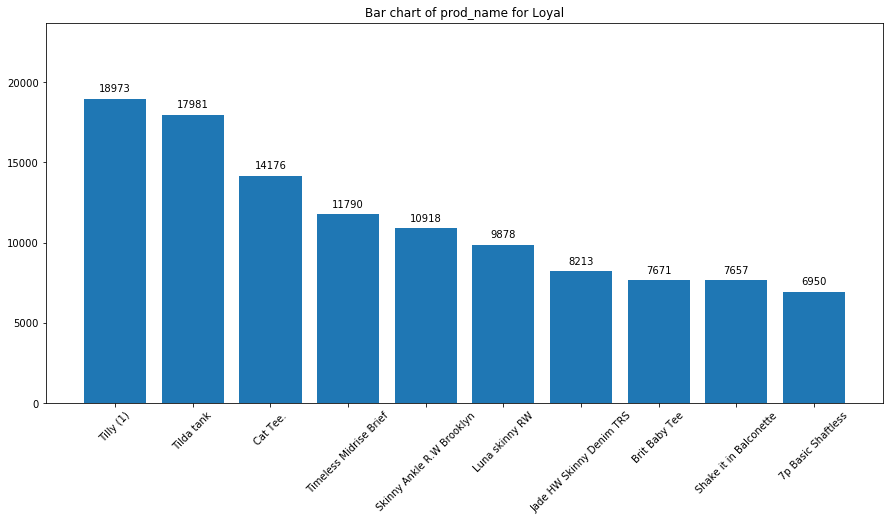



RFM Segment: Unprofitable


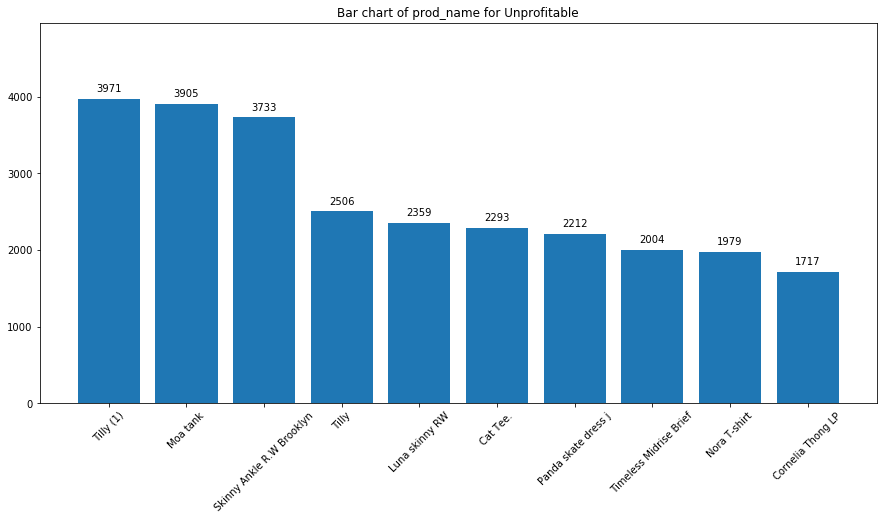



----- Variable: product_type_name -----
RFM Segment: Champions


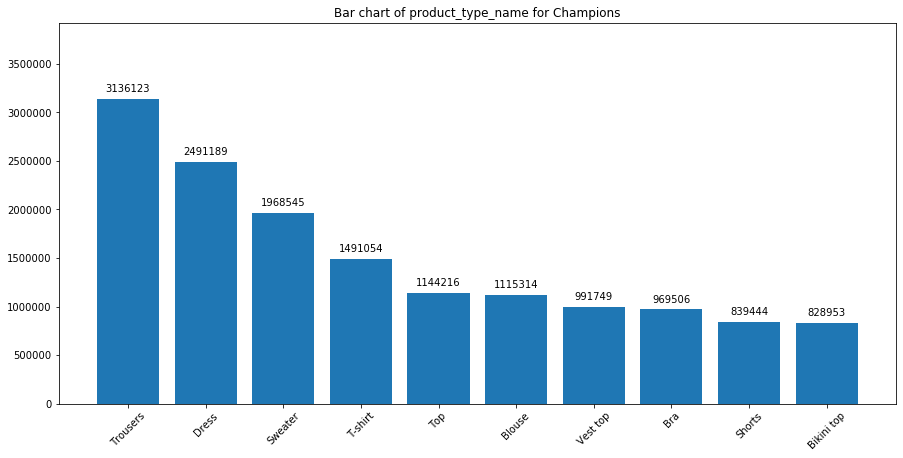



RFM Segment: Provide attention


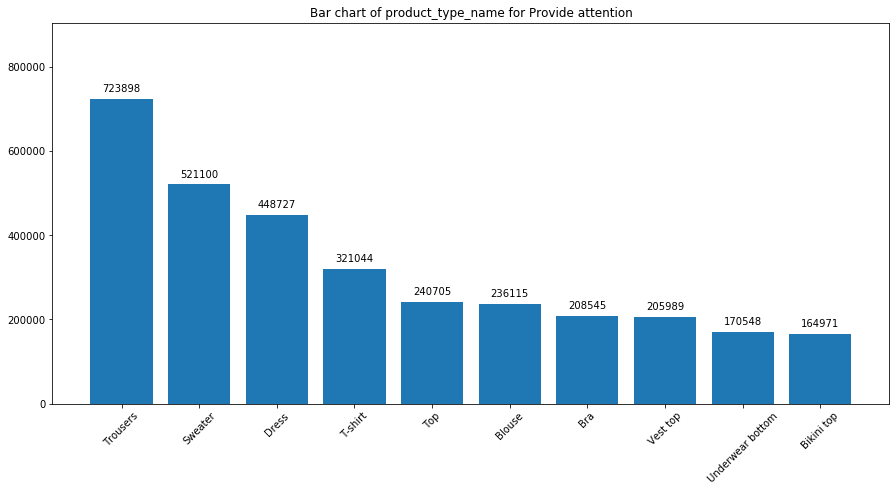



RFM Segment: Loyal


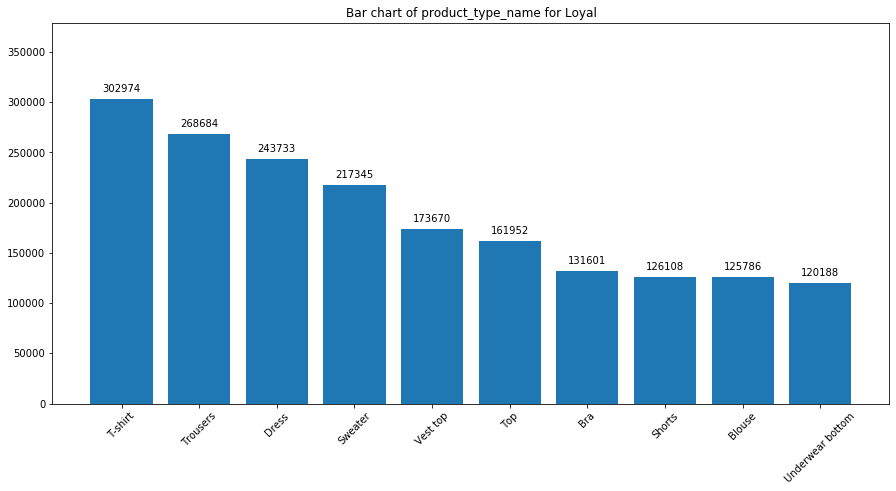



RFM Segment: Unprofitable


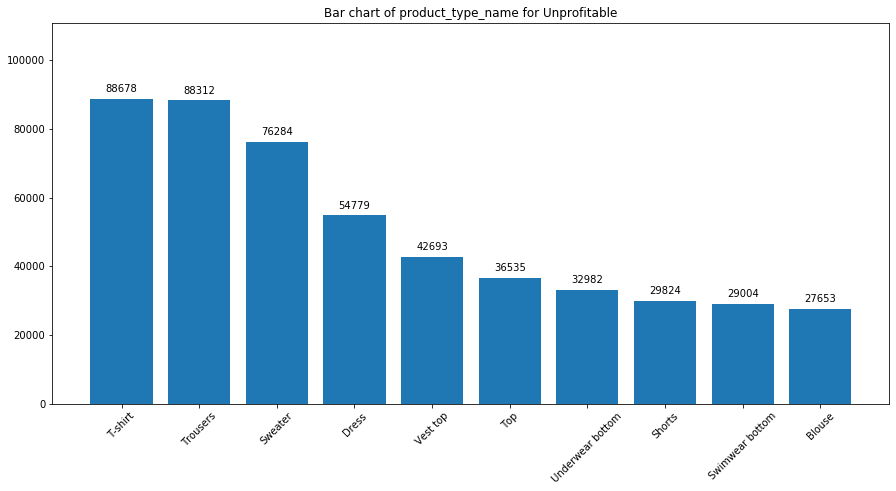



----- Variable: graphical_appearance_name -----
RFM Segment: Champions


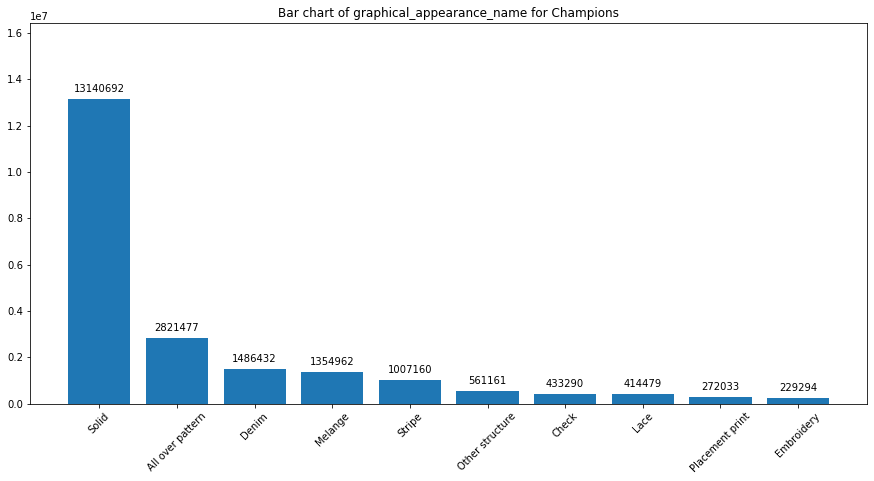



RFM Segment: Provide attention


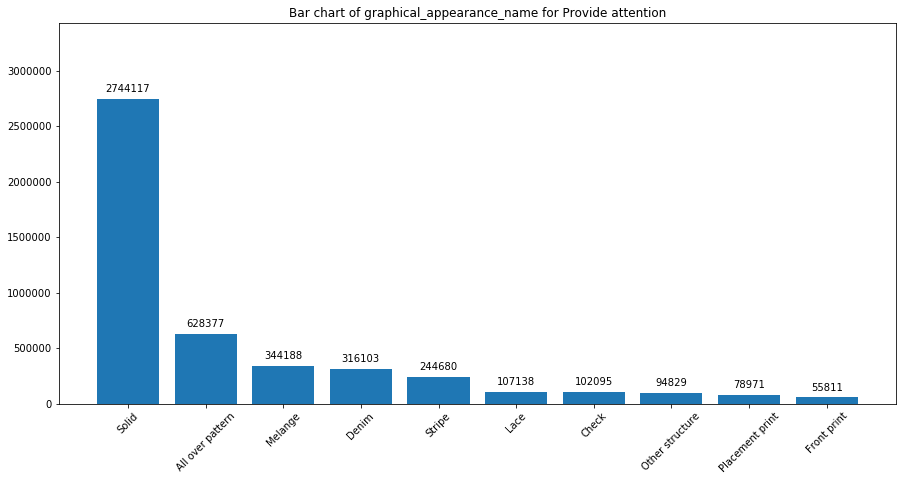



RFM Segment: Loyal


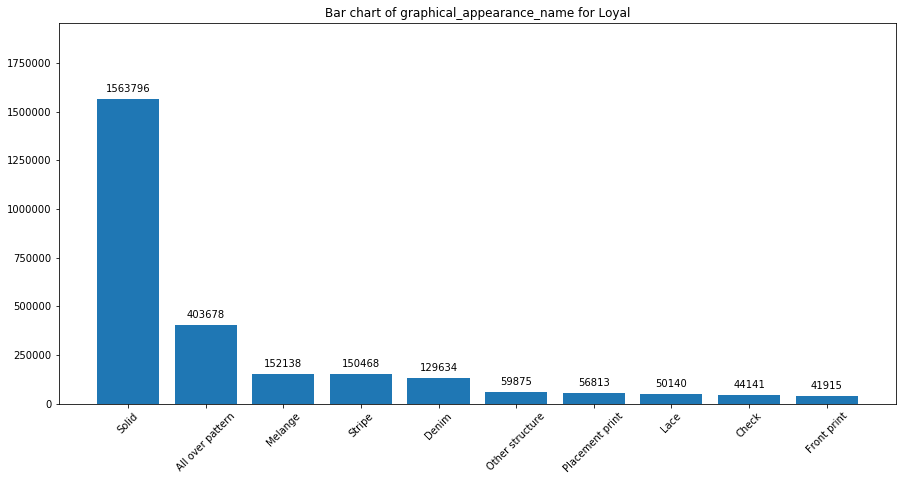



RFM Segment: Unprofitable


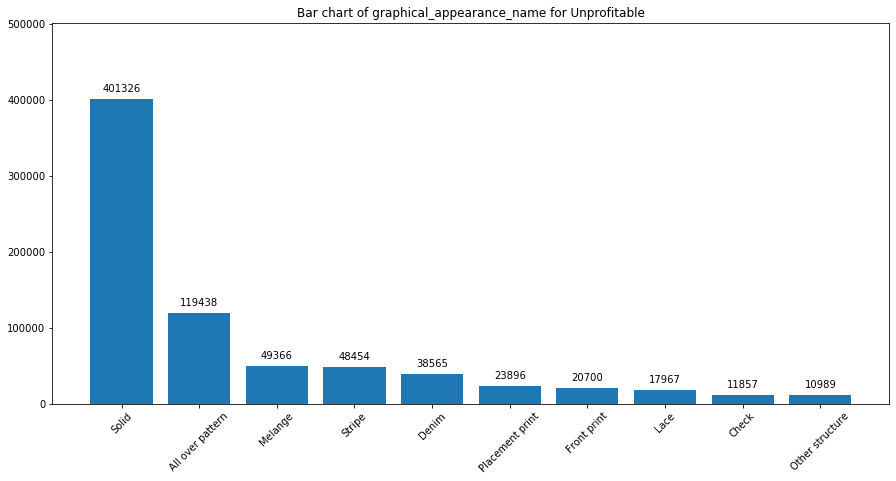



----- Variable: colour_group_name -----
RFM Segment: Champions


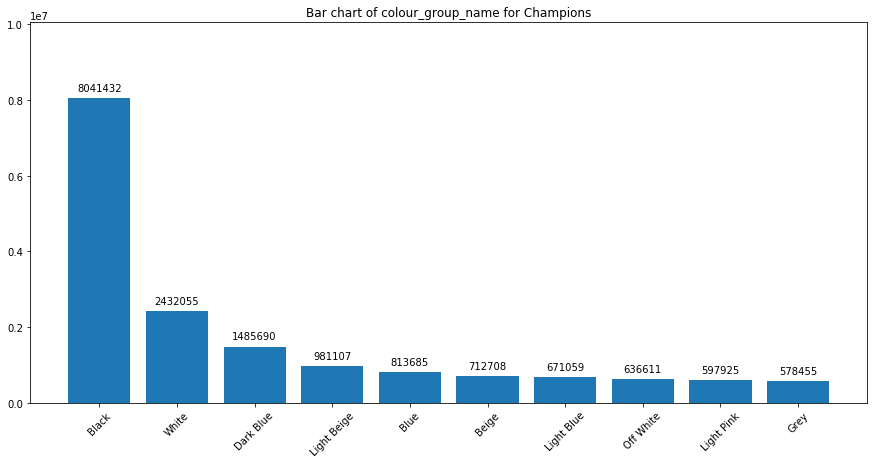



RFM Segment: Provide attention


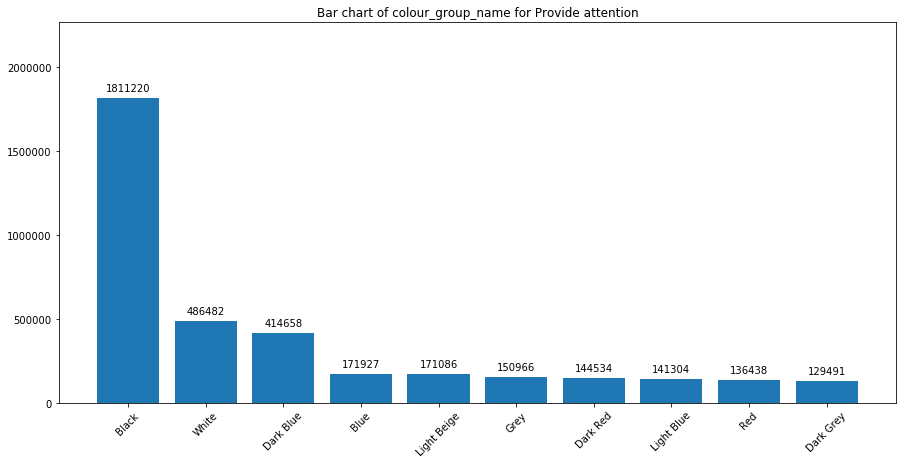



RFM Segment: Loyal


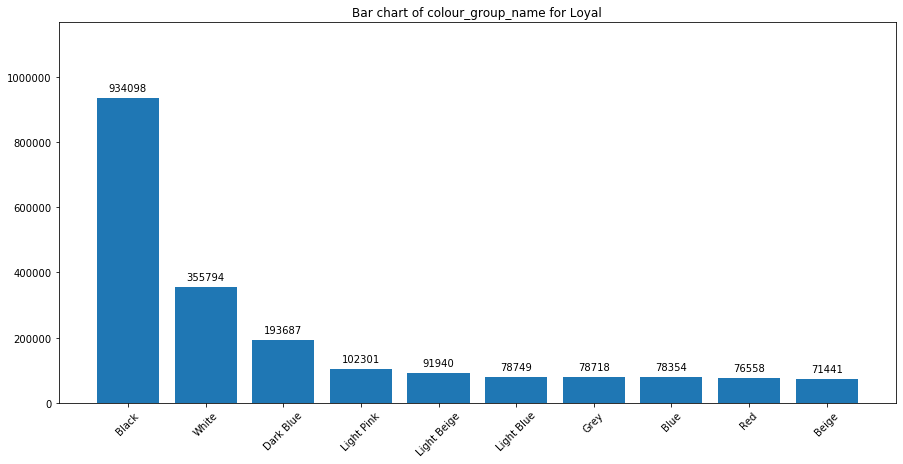



RFM Segment: Unprofitable


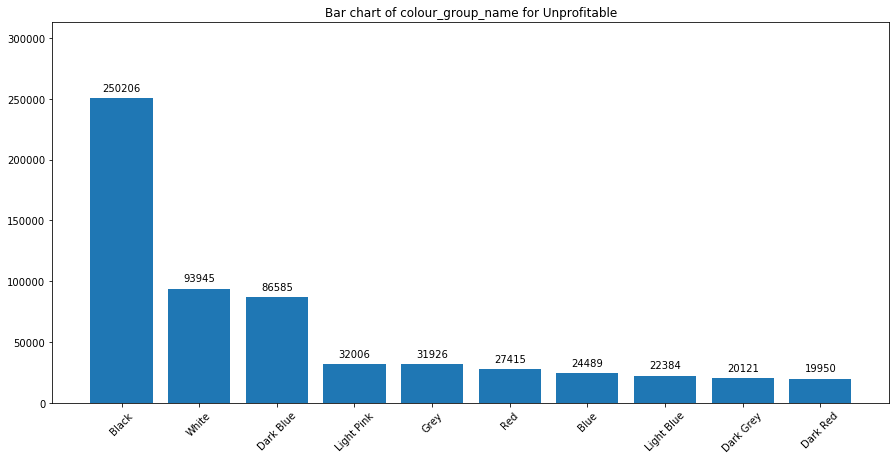



----- Variable: perceived_colour_value_name -----
RFM Segment: Champions


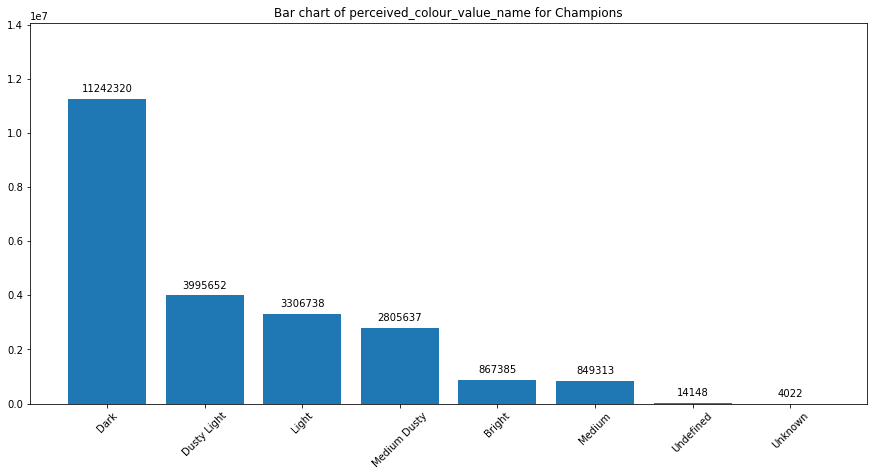



RFM Segment: Provide attention


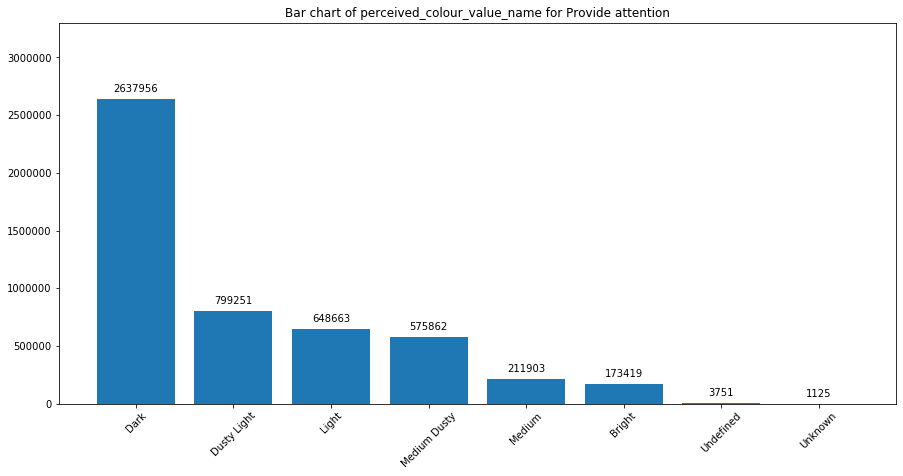



RFM Segment: Loyal


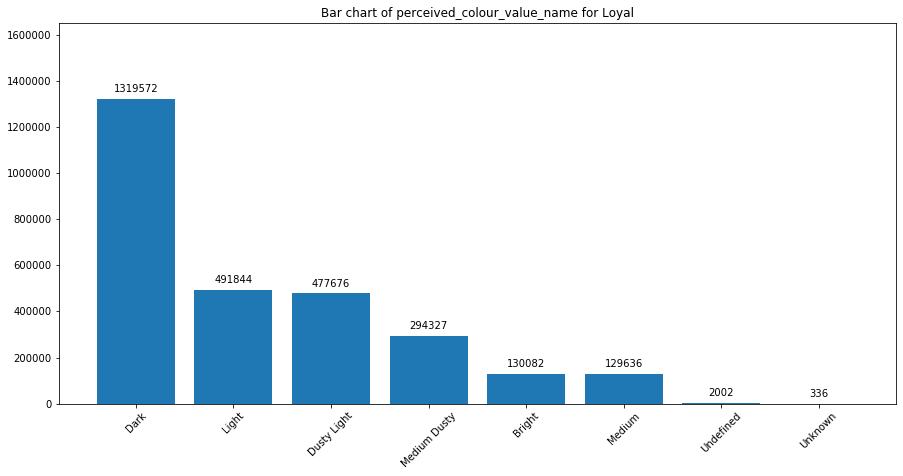



RFM Segment: Unprofitable


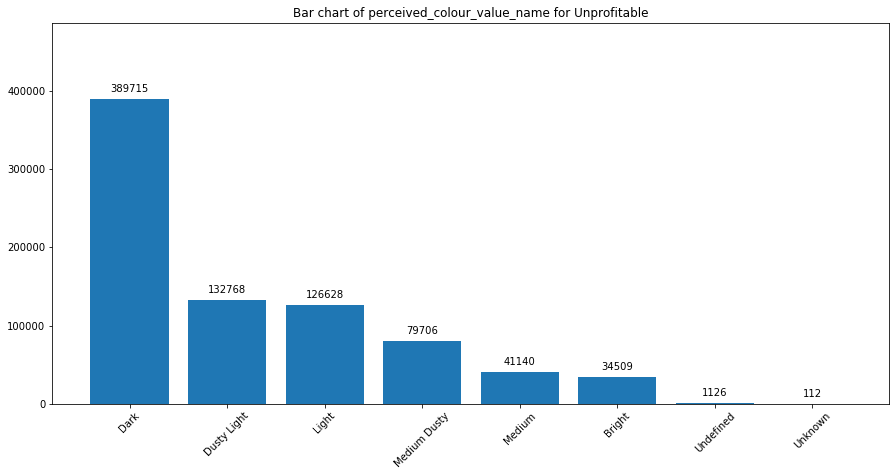



----- Variable: perceived_colour_master_name -----
RFM Segment: Champions


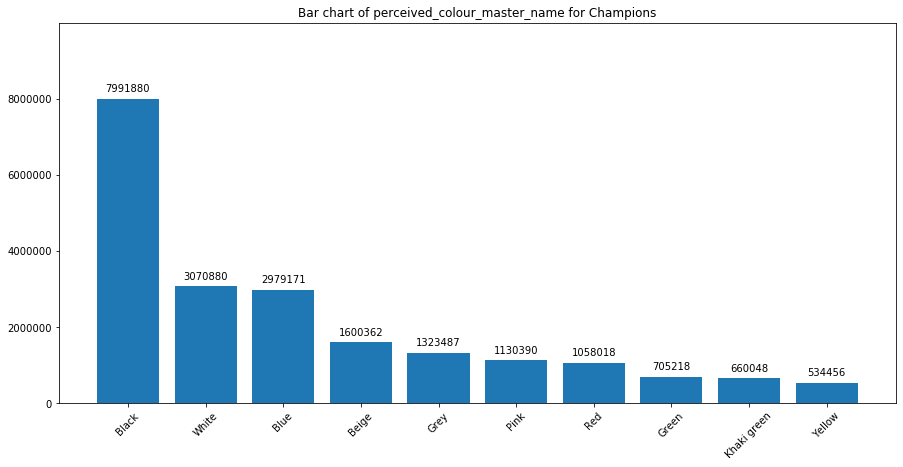



RFM Segment: Provide attention


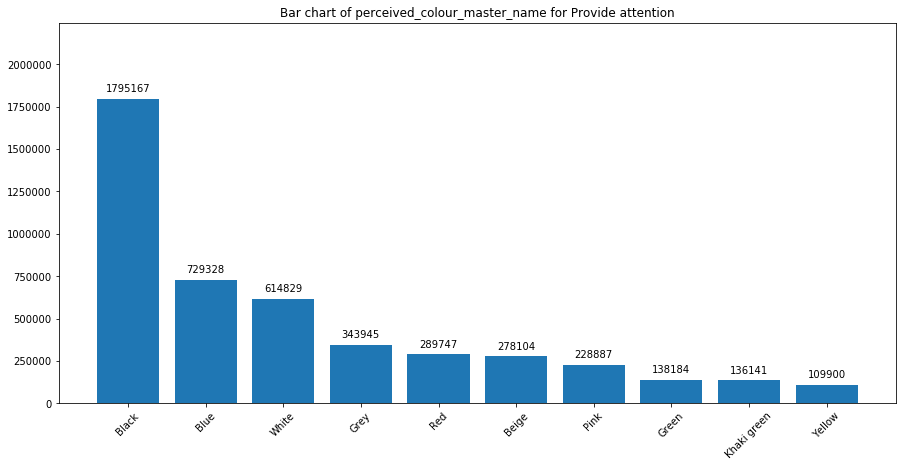



RFM Segment: Loyal


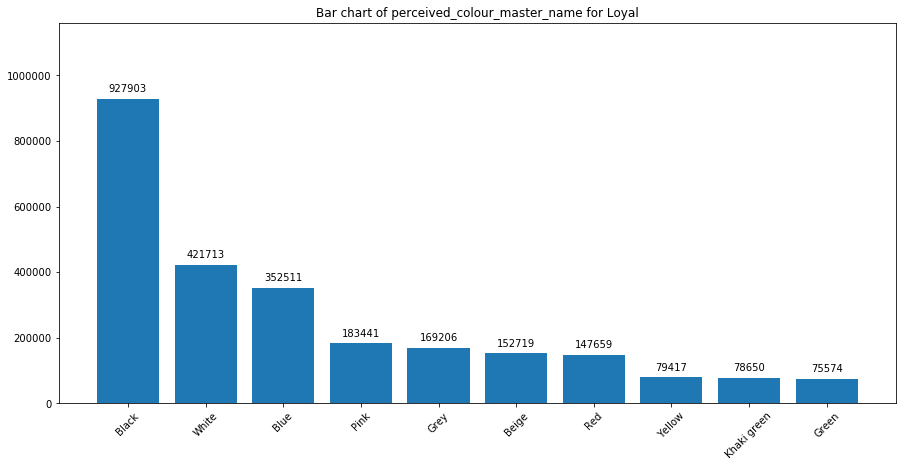



RFM Segment: Unprofitable


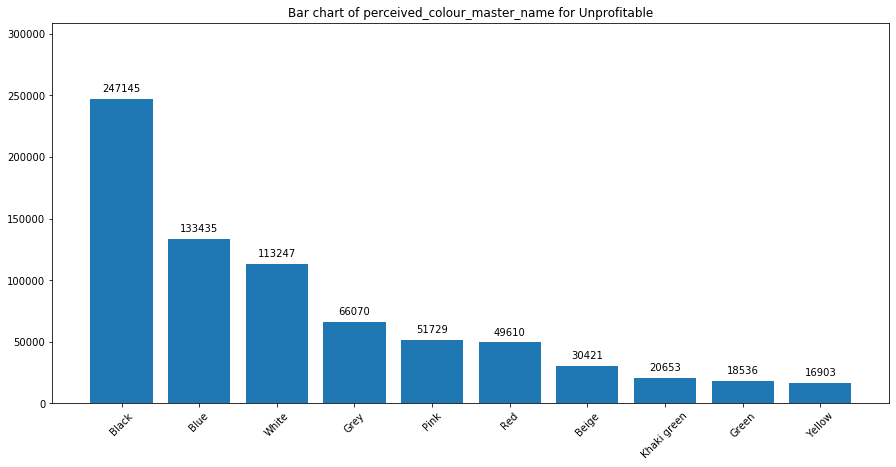



----- Variable: department_name -----
RFM Segment: Champions


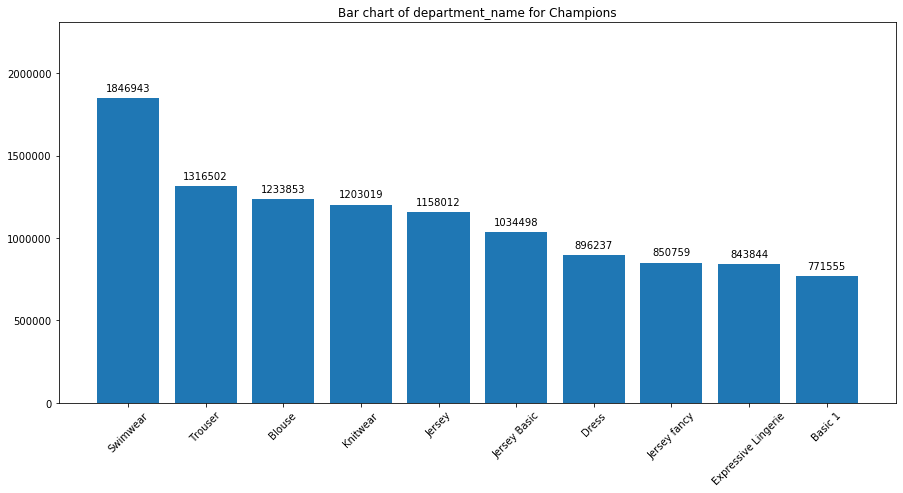



RFM Segment: Provide attention


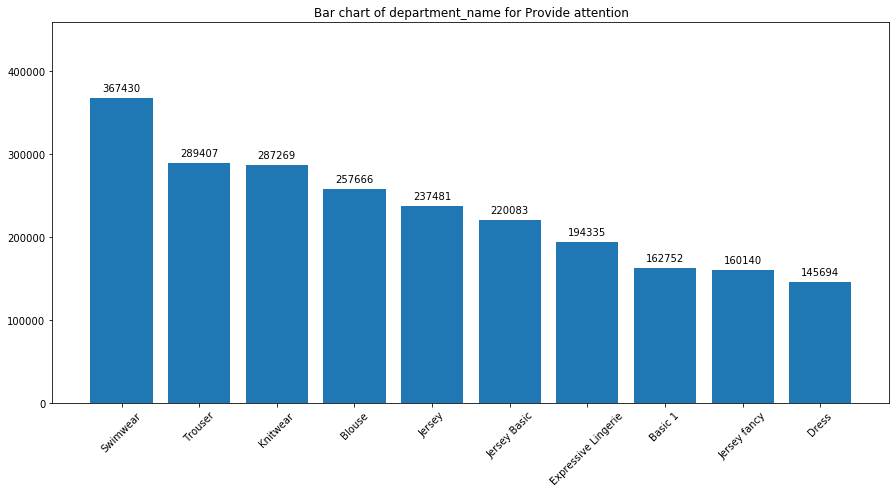



RFM Segment: Loyal


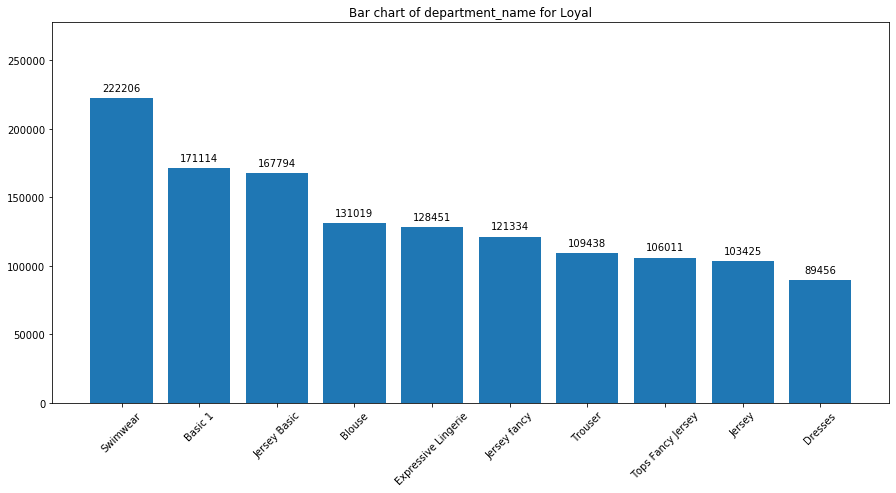



RFM Segment: Unprofitable


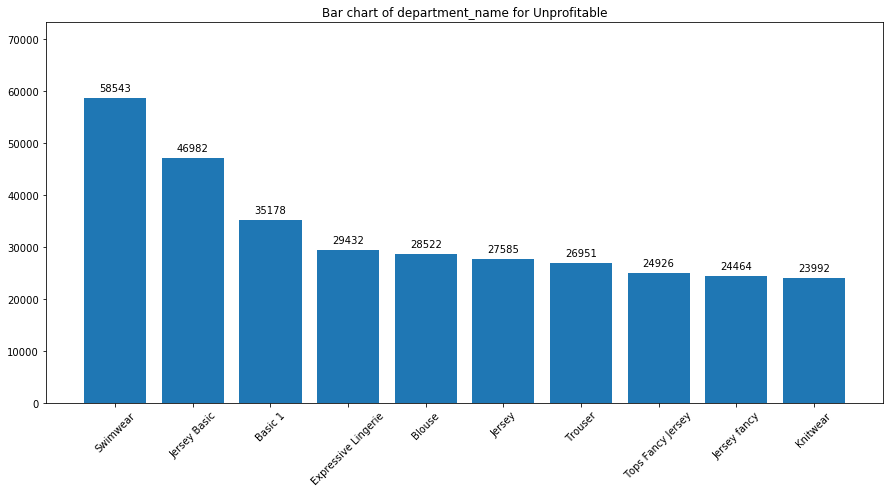



----- Variable: index_name -----
RFM Segment: Champions


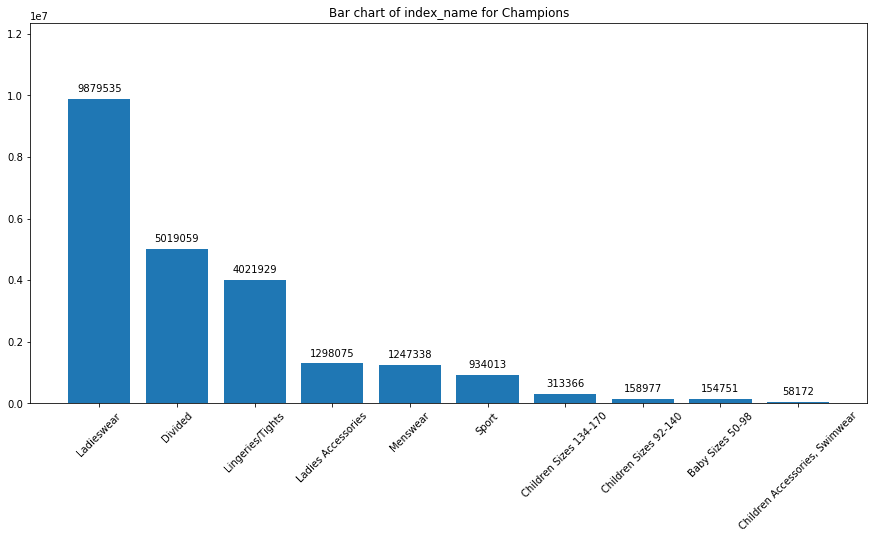



RFM Segment: Provide attention


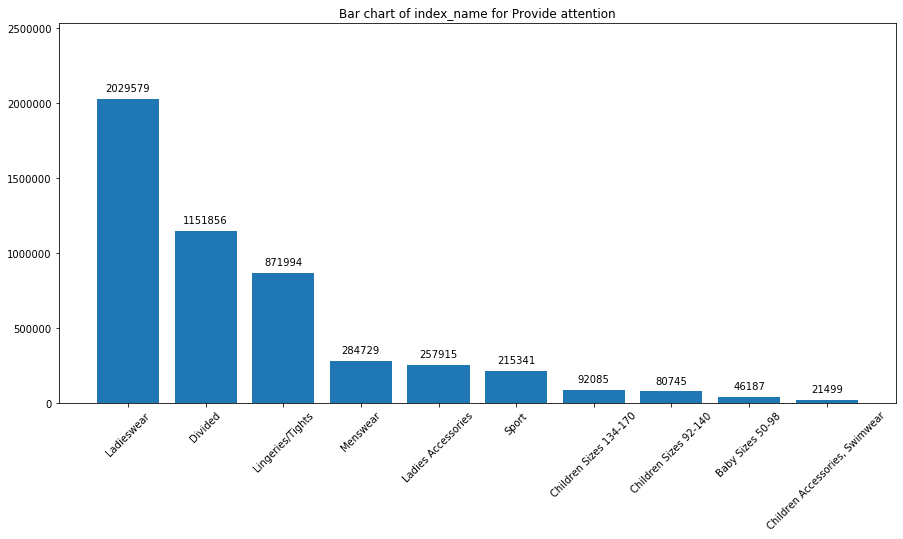



RFM Segment: Loyal


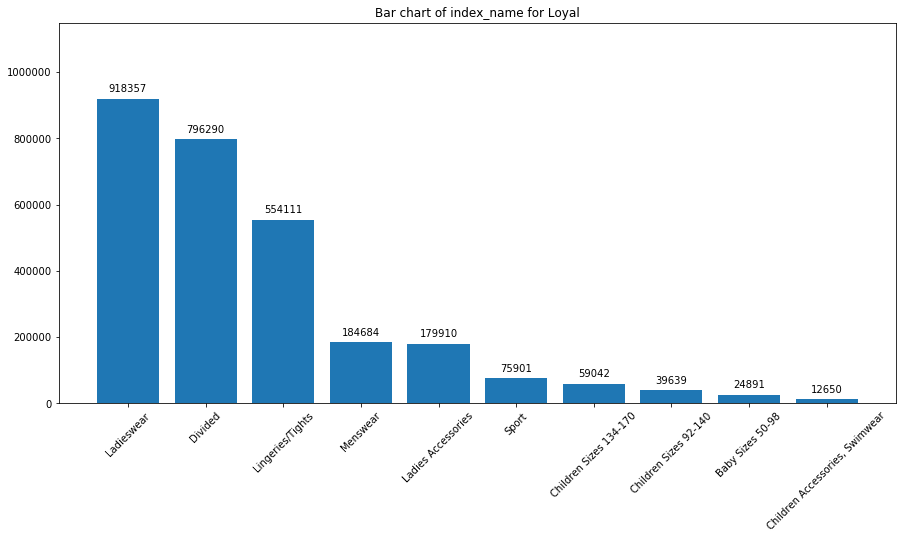



RFM Segment: Unprofitable


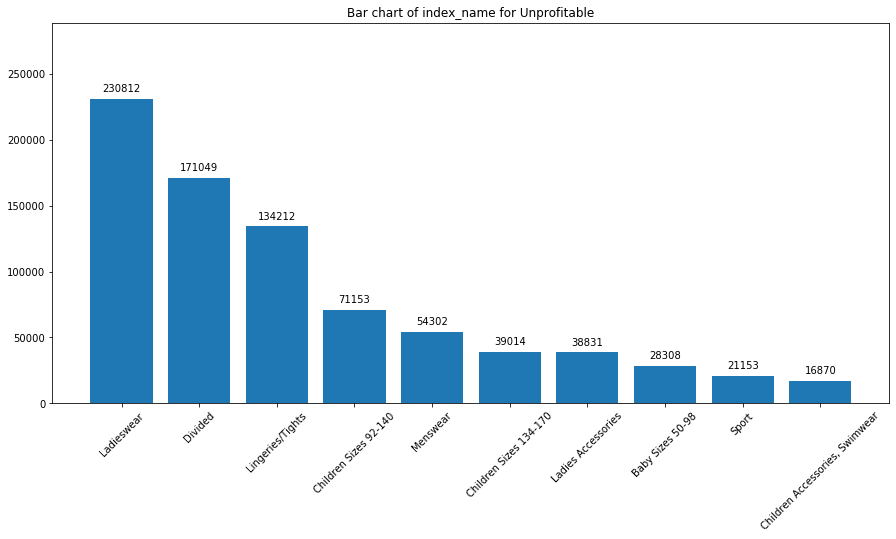



----- Variable: index_group_name -----
RFM Segment: Champions


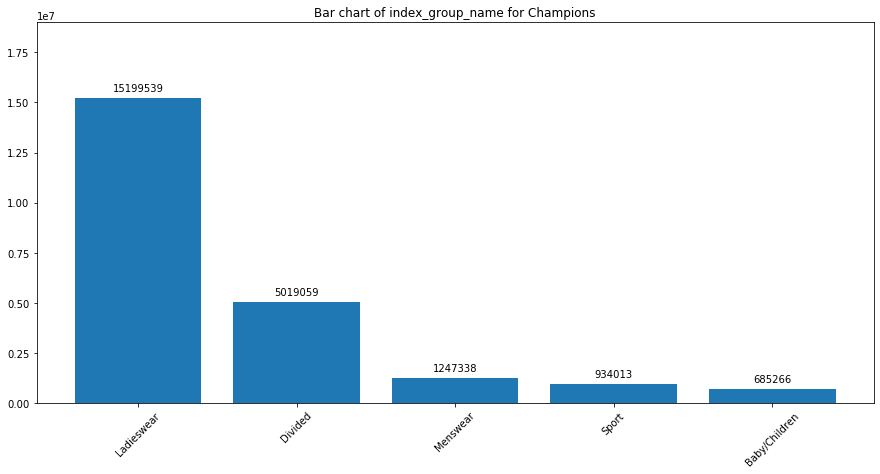



RFM Segment: Provide attention


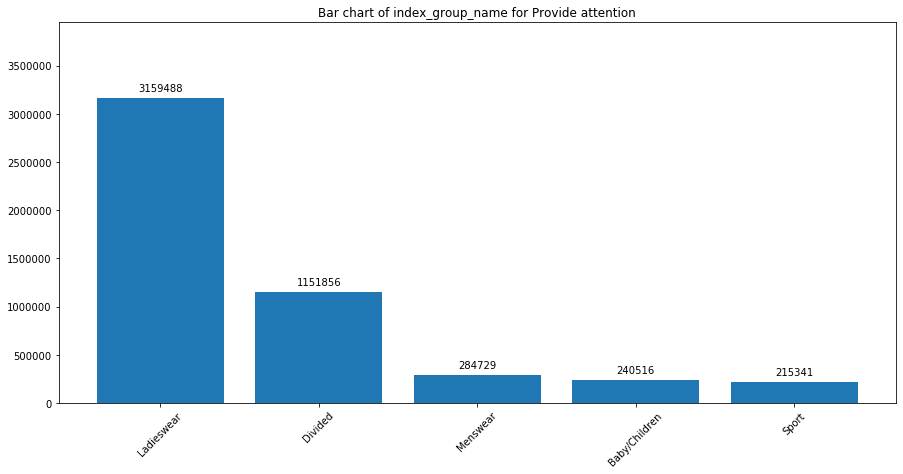



RFM Segment: Loyal


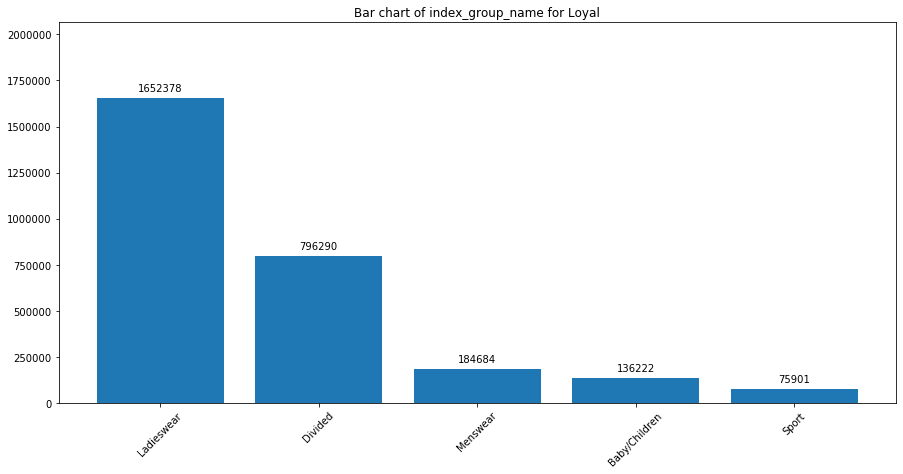



RFM Segment: Unprofitable


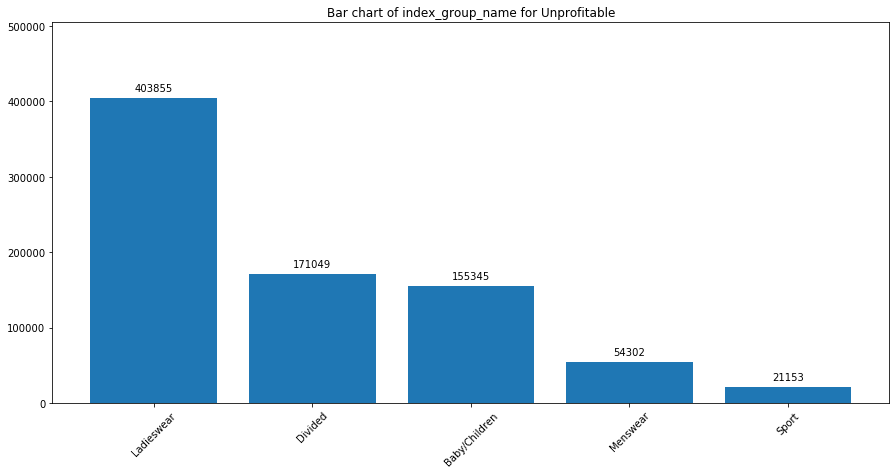



----- Variable: section_name -----
RFM Segment: Champions


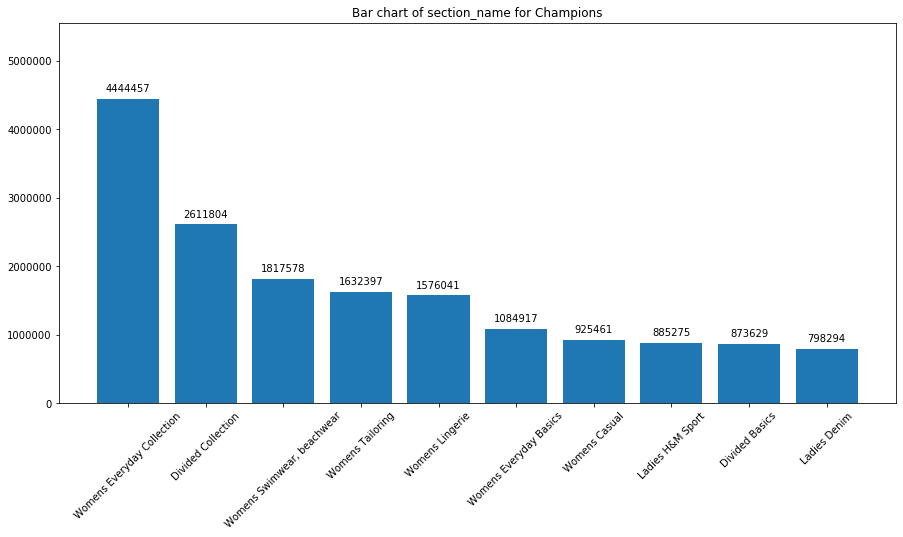



RFM Segment: Provide attention


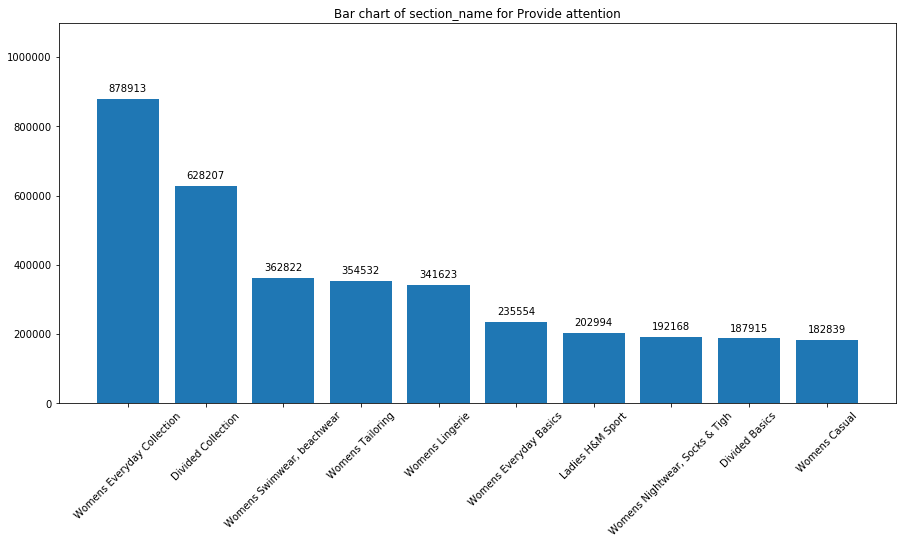



RFM Segment: Loyal


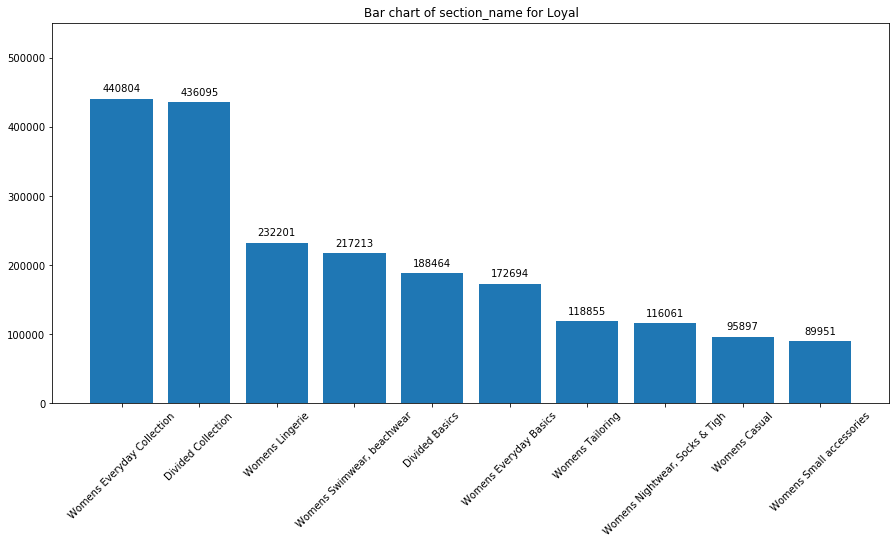



RFM Segment: Unprofitable


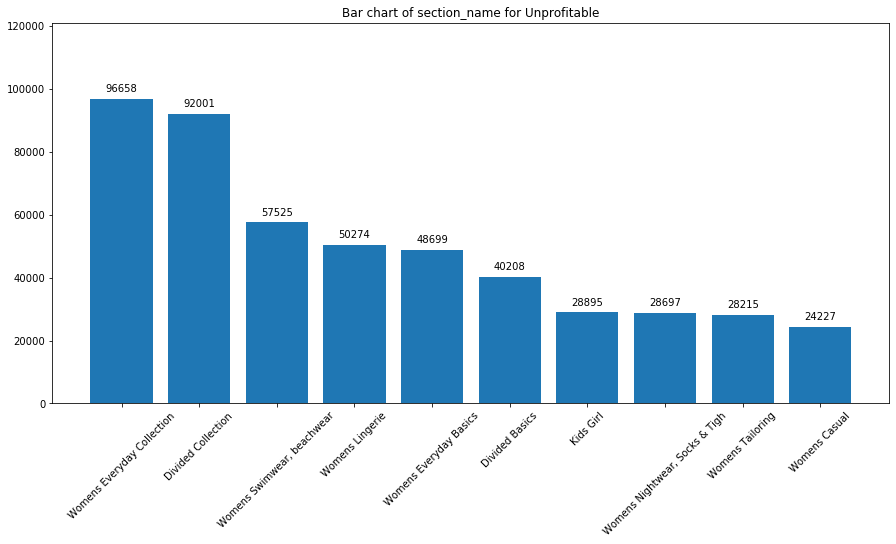



----- Variable: garment_group_name -----
RFM Segment: Champions


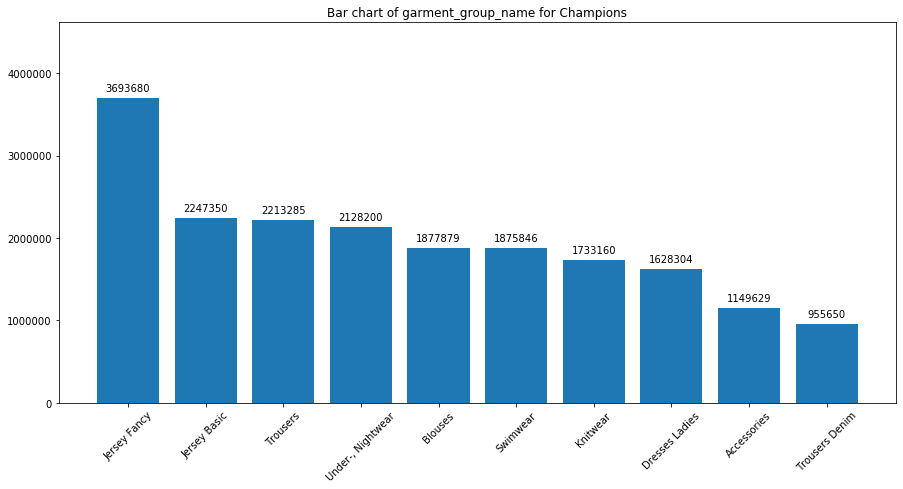



RFM Segment: Provide attention


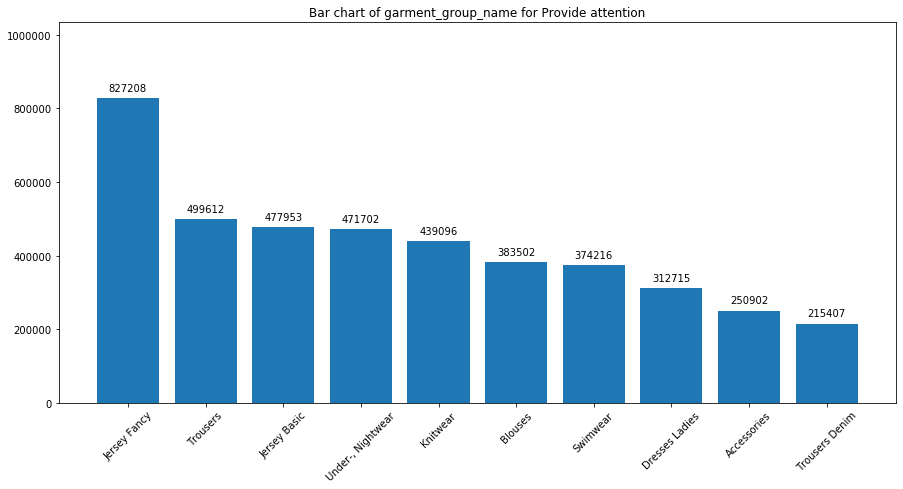



RFM Segment: Loyal


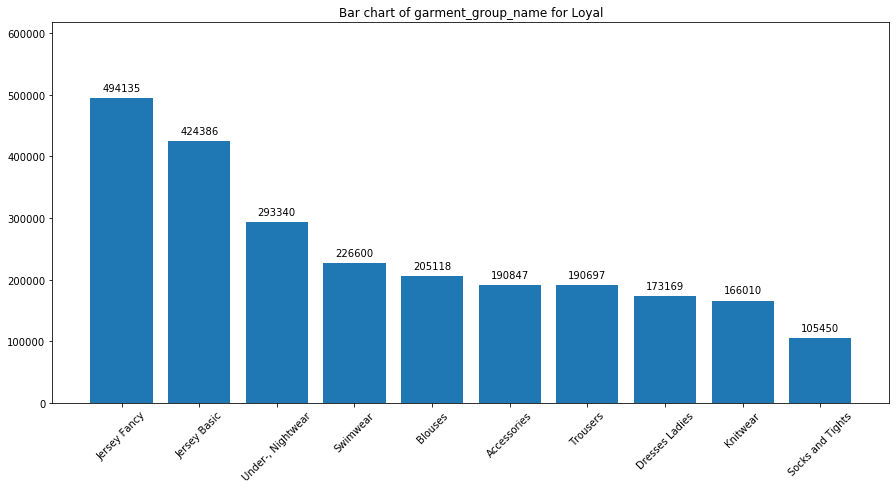



RFM Segment: Unprofitable


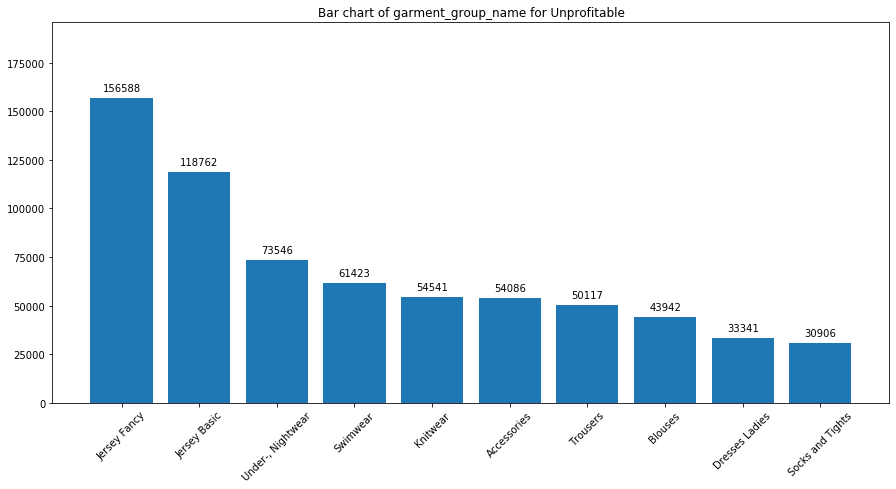



----- Variable: sales_channel_id -----
RFM Segment: Champions


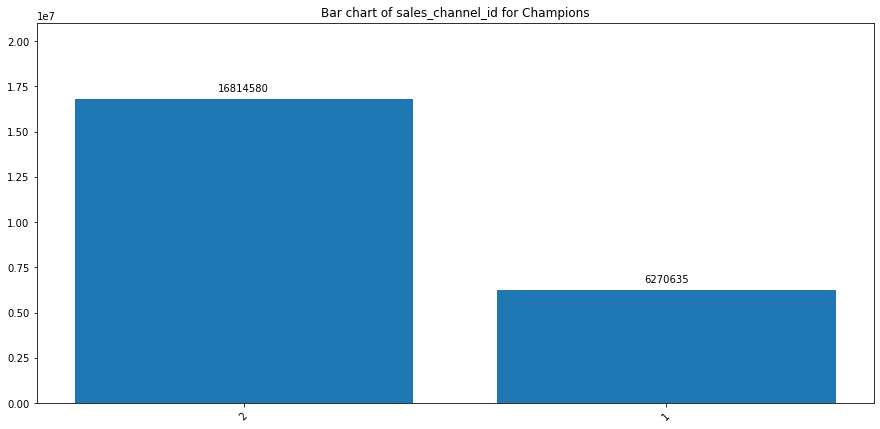



RFM Segment: Provide attention


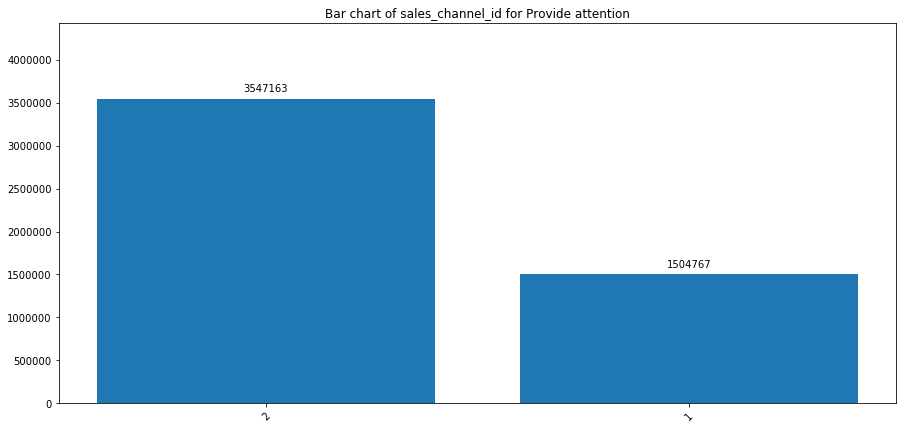



RFM Segment: Loyal


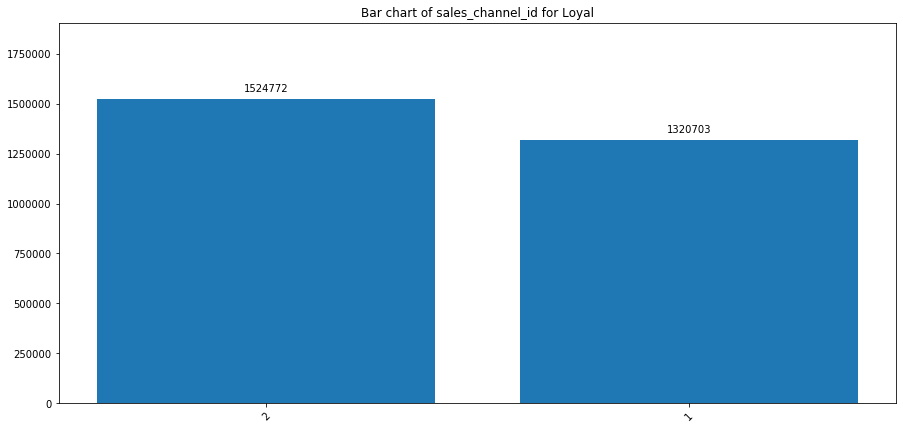



RFM Segment: Unprofitable


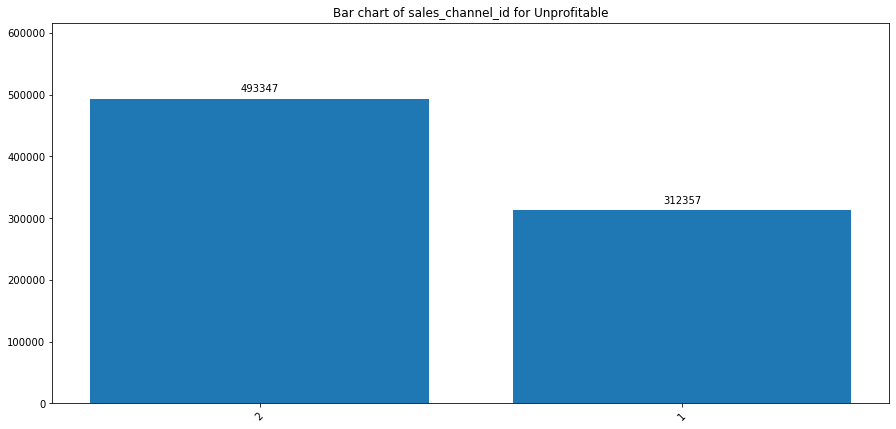

In [75]:
# Based on Top 10 categories in each column variable
labels = list(rfm_article_transact['rfm_label'].unique())
for col in ['prod_name','product_type_name','graphical_appearance_name','colour_group_name',
           'perceived_colour_value_name','perceived_colour_master_name','department_name',
           'index_name','index_group_name','section_name','garment_group_name','sales_channel_id']:
    print('----- Variable:',col,'-----')
    for label in labels:
        print('RFM Segment:',label)
        subset_df = rfm_article_transact[rfm_article_transact['rfm_label']==label]
        value_counts = subset_df[col].value_counts().loc[lambda x: x>0].to_frame()
        if len(value_counts) > 10:
            value_counts = value_counts[:10]
        barplot(value_counts, label, col, value_counts.index, rotate=True)
        print('\n')

#### Others

In [78]:
rfm_article_transact.head()

,customer_id,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name,price,sales_channel_id,rfm_label
0,05ed96931b707698bc94aa53766d44686ae5ccbbc99dfb...,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,0.008458,1,Champions
1,05ed96931b707698bc94aa53766d44686ae5ccbbc99dfb...,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,0.008458,1,Champions
2,05ed96931b707698bc94aa53766d44686ae5ccbbc99dfb...,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,0.008458,1,Champions
3,05ed96931b707698bc94aa53766d44686ae5ccbbc99dfb...,Theron,Hoodie,Garment Upper body,Melange,Light Blue,Light,Blue,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,0.033881,1,Champions
4,05ed96931b707698bc94aa53766d44686ae5ccbbc99dfb...,Clubba sunglasses,Sunglasses,Accessories,Solid,Yellowish Brown,Dark,Brown,Sunglasses,Ladies Accessories,Ladieswear,Womens Small accessories,Accessories,0.006763,1,Champions


In [84]:
price_rfm = rfm_article_transact.loc[:,['price','rfm_label']]
price_rfm.head()

,price,rfm_label
0,0.008458,Champions
1,0.008458,Champions
2,0.008458,Champions
3,0.033881,Champions
4,0.006763,Champions


In [85]:
price_rfm['price'] *= 1000
price_rfm.head()

,price,rfm_label
0,8.457627,Champions
1,8.457627,Champions
2,8.457627,Champions
3,33.881356,Champions
4,6.762712,Champions


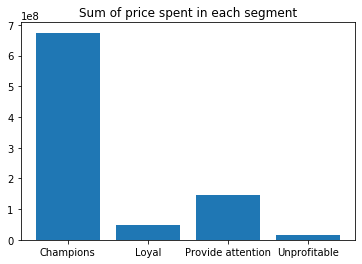

,rfm_label,price
0,Champions,6.743244e+08
1,Loyal,4.794562e+07
2,Provide attention,1.464612e+08
3,Unprofitable,1.591476e+07


In [88]:
price_sum = pd.DataFrame(price_rfm.groupby('rfm_label')['price'].sum()).reset_index()
plt.bar(price_sum['rfm_label'],price_sum['price'])
plt.title('Sum of price spent in each segment')
plt.show()

price_sum

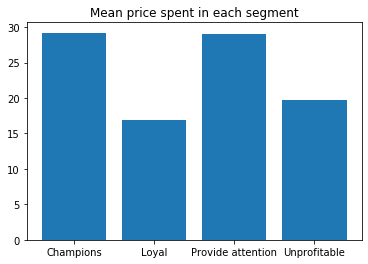

,rfm_label,price
0,Champions,29.210228
1,Loyal,16.849777
2,Provide attention,28.991141
3,Unprofitable,19.752610


In [89]:
price_mean = pd.DataFrame(price_rfm.groupby('rfm_label')['price'].mean()).reset_index()
plt.bar(price_mean['rfm_label'],price_mean['price'])
plt.title('Mean price spent in each segment')
plt.show()

price_mean

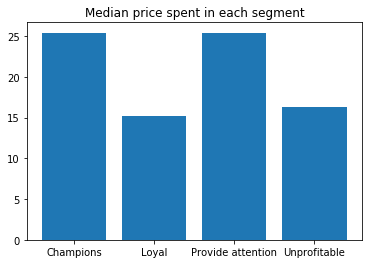

,rfm_label,price
0,Champions,25.406780
1,Loyal,15.237288
2,Provide attention,25.406780
3,Unprofitable,16.305085


In [90]:
price_median = pd.DataFrame(price_rfm.groupby('rfm_label')['price'].median()).reset_index()
plt.bar(price_median['rfm_label'],price_median['price'])
plt.title('Median price spent in each segment')
plt.show()

price_median